# Import libs

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

# Process features dataset and split dataset for train, eval, test

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [3]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [4]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


Выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [5]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [263]:
popularity = data.groupby(by='item_id').agg('quantity').sum().sort_values(ascending=False)
popularity = popularity.tolist()

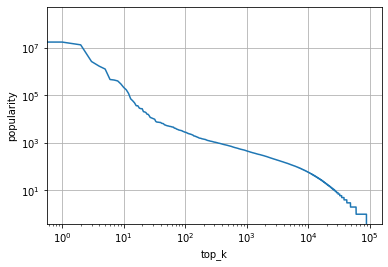

In [307]:
plt.plot(popularity[:]) 
plt.semilogx()
plt.semilogy()
plt.xlabel('top_k')
plt.ylabel('popularity')
plt.grid()
plt.show()

Топ-5000 товаров подходящая отсечка.

In [6]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Илья\Desktop\GeekBrains\Рекомендательные системы\webinar_6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [7]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [8]:
recommender = MainRecommender(data_train_matcher)

In [9]:
ACTUAL_COL = 'actual'

result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


Увеличение количества кандидатов не снижает качество предсказаний модели второго уровня, оптимальный результат N_PREDICT = 40.

In [1]:
N_PREDICT = 40

In [11]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 33min 25s


In [12]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [13]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [14]:
TOPK_RECALL = 40

In [15]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.08904618728423232),
 ('als_rec', 0.06586307980507604),
 ('sim_item_rec', 0.03893042711754625)]

In [16]:
TOPK_PRECISION = 5

In [17]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.3237563923756395),
 ('als_rec', 0.16968851696884926),
 ('sim_item_rec', 0.06861924686192487)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

## Подготовка данных для трейна

In [108]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [109]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1029743, 913210, 1016800, 933067, 838186, 926..."
1,2021,"[950935, 1119454, 844179, 1044078, 6534077, 10..."


In [110]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [111]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1029743
0,2070,913210
0,2070,1016800
0,2070,933067


### Check warm start

In [112]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (86040, 2) Users: 2151 Items: 4723


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [196]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [197]:
data_train_ranker.shape

(169615, 12)

In [198]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

df_ranker_train.target.value_counts()

0.0    74108
1.0    11476
Name: target, dtype: int64

In [199]:
df_ranker_train.shape

(85584, 3)

## Подготавливаем фичи для обучения модели

In [200]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [201]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [202]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Фичи user_id

**Найдем средний чек для каждого юзера (average order value)**

In [203]:
data_train_ranker.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [204]:
aov_df = data_train_ranker.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value': 'sum'}).rename(columns={'sales_value': 'order_value'})
aov_df = aov_df.groupby(['user_id'], as_index=False).agg({'order_value': 'mean'}).rename(columns={'order_value': 'aov'})
aov_df.head(2)

,user_id,aov
0,1,48.825714
1,2,47.572500


**Средняя сумма покупки 1 товара в каждой категории**

In [205]:
aov_one_item_by_category = data_train_ranker.copy()
aov_one_item_by_category = aov_one_item_by_category.merge(item_features[['item_id','department']], on='item_id', how='left')
aov_one_item_by_category = aov_one_item_by_category.groupby(['user_id', 'department'], as_index=False).agg({'quantity': 'sum', 'sales_value': 'sum'})
aov_one_item_by_category['aov_one_item_by_category'] = aov_one_item_by_category.sales_value / aov_one_item_by_category.quantity
aov_one_item_by_category = pd.pivot_table(aov_one_item_by_category,
                                          index='user_id',
                                          columns='department',
                                          values='aov_one_item_by_category',
                                          aggfunc='sum',
                                          fill_value=0,
                                          )
aov_one_item_by_category.head(2)

department,,AUTOMOTIVE,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DELI,DELI/SNACK BAR,DRUG GM,FLORAL,...,PHOTO,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TRAVEL & LEISUR,VIDEO
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0.0,0,0.0,0.0,2.4375,0.0,4.143846,0.0,...,0.0,1.067143,0.0,0.0,3.71,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0,0.0,0.0,0.0000,0.0,3.645556,0.0,...,0.0,1.810000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


**Кол-во покупок в каждой категории**

In [206]:
q_purchase_by_department = data_train_ranker.copy()
q_purchase_by_department = q_purchase_by_department.merge(item_features[['item_id','department']], on='item_id', how='left')
q_purchase_by_department = q_purchase_by_department.groupby(['user_id', 'department'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'q_purchase_by_department'})
q_purchase_by_department = pd.pivot_table(q_purchase_by_department,
                                          index='user_id',
                                          columns='department',
                                          values='q_purchase_by_department',
                                          aggfunc='sum',
                                          fill_value=0,
                                          )
for col in q_purchase_by_department.columns.tolist():
    new_col = 'qpbd_' + col
    q_purchase_by_department.rename(columns={col: new_col}, inplace=True)
q_purchase_by_department.head(4)

department,qpbd_,qpbd_AUTOMOTIVE,qpbd_CHEF SHOPPE,qpbd_CNTRL/STORE SUP,qpbd_COSMETICS,qpbd_COUP/STR & MFG,qpbd_DELI,qpbd_DELI/SNACK BAR,qpbd_DRUG GM,qpbd_FLORAL,...,qpbd_PHOTO,qpbd_PRODUCE,qpbd_RESTAURANT,qpbd_RX,qpbd_SALAD BAR,qpbd_SEAFOOD,qpbd_SEAFOOD-PCKGD,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,4,0,13,0,...,0,14,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,0,0,9,0,...,0,6,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,5,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,24,0,...,0,38,0,0,0,0,1,0,0,0


**Частотность покупок раз/неделя**

In [207]:
time_interval = data_train_ranker['week_no'].max() - data_train_ranker['week_no'].min()
frec_purchase = data_train_ranker.groupby(['user_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'frec_purchase'})
frec_purchase.frec_purchase = frec_purchase.frec_purchase / time_interval
frec_purchase.head(4)

,user_id,frec_purchase
0,1,29.6
1,2,16.8
2,4,7.6
3,6,28.2


### Фичи item_id

**Кол-во покупок в неделю**

In [308]:
data_train_items = data[data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS)]

In [208]:
time_interval = data_train_items['week_no'].max() - data_train_items['week_no'].min()
items_week = data_train_items.groupby(['item_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'items_week'})
items_week.items_week = items_week.items_week / time_interval
items_week.head(2)
# Пропуски заполним нулями - это отвечает логике

,item_id,items_week
0,25671,0.066667
1,26081,0.011111


**Среднее кол-во покупок 1 товара в категории в неделю**

In [209]:
average_purchase_by_department = data_train_items.copy()
average_purchase_by_department = average_purchase_by_department.merge(item_features[['item_id','department']], on='item_id', how='left')
average_purchase_by_department = average_purchase_by_department.groupby(['department', 'item_id'], as_index=False).agg({'quantity': 'sum'}).rename(columns={'quantity': 'average_purchase_by_department'})
average_purchase_by_department = average_purchase_by_department.groupby(['department'], as_index=False).agg({'average_purchase_by_department': 'mean'})
average_purchase_by_department.average_purchase_by_department = average_purchase_by_department.average_purchase_by_department / time_interval
average_purchase_by_department.head(4)

,department,average_purchase_by_department
0,,0.000000
1,AUTOMOTIVE,0.327778
2,CHARITABLE CONT,0.016667
3,CHEF SHOPPE,0.656481


**(Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)**

In [210]:
items_week_vs_apbd = data_train_items.copy()
items_week_vs_apbd = items_week_vs_apbd.merge(items_week, on='item_id', how='left')
items_week_vs_apbd = items_week_vs_apbd.merge(item_features[['item_id','department']], on='item_id', how='left')
items_week_vs_apbd = items_week_vs_apbd.merge(average_purchase_by_department, on='department', how='left')
items_week_vs_apbd.loc[items_week_vs_apbd['average_purchase_by_department'] == 0, 'average_purchase_by_department'] = 1
items_week_vs_apbd['items_week_vs_apbd'] = items_week_vs_apbd.items_week / items_week_vs_apbd.average_purchase_by_department
items_week_vs_apbd = items_week_vs_apbd[['item_id', 'items_week_vs_apbd']]
items_week_vs_apbd = items_week_vs_apbd.drop_duplicates(subset=['item_id'])
items_week_vs_apbd.head(4)

,item_id,items_week_vs_apbd
0,1004906,36.281560
1,1033142,24.477987
2,1036325,2.266286
3,1082185,284.376924


**Цена / Средняя цена товара в категории**

In [212]:
price_vs_apc = data_train_items.copy()
price_vs_apc.loc[price_vs_apc['quantity']==0, 'quantity'] = 1
price_vs_apc['price'] = price_vs_apc['sales_value'] / price_vs_apc['quantity']
price_vs_apc.loc[price_vs_apc['price']==0, 'price'] = 1
price_vs_apc = price_vs_apc.merge(item_features[['item_id','department']], on='item_id', how='left')
price_vs_apc = price_vs_apc.drop_duplicates(subset=['item_id'])
apc = price_vs_apc.groupby(['department'], as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'apc'})
price_vs_apc = price_vs_apc.merge(apc, on='department', how='left')
price_vs_apc.loc[price_vs_apc['apc']==0, 'apc'] = 1
price_vs_apc['price_vs_apc'] = price_vs_apc.price / price_vs_apc.apc
price_vs_apc = price_vs_apc[['item_id', 'price', 'price_vs_apc']]
price_vs_apc.head(2)

,item_id,price,price_vs_apc
0,1004906,1.39,0.568198
1,1033142,0.82,0.335196


### Фичи user-item

In [213]:
# Сохраним основные фичи
main_features = df_ranker_train.drop(columns=['target']).columns.tolist()
main_features

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [214]:
df_ranker_train = df_ranker_train.merge(aov_df, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(aov_one_item_by_category, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(q_purchase_by_department, on='user_id', how='left')
df_ranker_train = df_ranker_train.merge(frec_purchase, on='user_id', how='left')

df_ranker_train = df_ranker_train.merge(items_week, on='item_id', how='left')
df_ranker_train.items_week.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(average_purchase_by_department, on='department', how='left')
df_ranker_train.average_purchase_by_department.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(items_week_vs_apbd, on='item_id', how='left')
df_ranker_train.items_week_vs_apbd.fillna(0, inplace=True)
df_ranker_train = df_ranker_train.merge(price_vs_apc, on='item_id', how='left')

df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_SEAFOOD-PCKGD,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,1,0,0,0,3510.0,166.833333,0.574919,290.185851,2.49,0.873676
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,1,0,0,0,3510.0,15.155556,0.574919,26.361205,3.99,1.399986
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,1,0,0,0,3510.0,8.277778,0.574919,14.398166,0.82,0.287716
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,1,0,0,0,3510.0,7.900000,0.623835,12.663609,2.50,0.808983
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,1,0,0,0,3510.0,8.355556,0.574919,14.533451,4.49,1.575423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85579,1745,837908,0.0,1508,MEAT-PCKGD,National,FROZEN MEAT,FRZN MULTI SERVE ENTREES ALL,28 OZ,45-54,...,0,0,0,0,1.0,0.722222,0.623835,1.157714,2.50,0.808983
85580,1745,13909964,0.0,1425,MEAT-PCKGD,National,HOT DOGS,ECONOMY - BEEF,16 OZ,45-54,...,0,0,0,0,1.0,0.800000,0.623835,1.282391,2.99,0.967544
85581,1745,8011291,0.0,69,PASTRY,Private,PIES,PIES: FRUIT/NUT,,45-54,...,0,0,0,0,1.0,1.166667,0.242980,4.801502,4.99,1.174887
85582,1745,1002787,0.0,1216,MEAT-PCKGD,National,FROZEN MEAT,BEEF - FULLY COOKED,42 OZ,45-54,...,0,0,0,0,1.0,1.444444,0.623835,2.315428,7.16,2.316928


In [215]:
def get_aov_by_department(x):
    col = x['department']
    return x[col] / x['price']

In [216]:
df_ranker_train['aov_cat_vs_price'] = df_ranker_train.apply(lambda x: get_aov_by_department(x), axis=1)
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_SPIRITS,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc,aov_cat_vs_price
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,0,0,0,3510.0,166.833333,0.574919,290.185851,2.49,0.873676,0.586968
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,0,0,0,3510.0,15.155556,0.574919,26.361205,3.99,1.399986,0.366303
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0,0,0,3510.0,8.277778,0.574919,14.398166,0.82,0.287716,1.782377
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,0,0,0,3510.0,7.900000,0.623835,12.663609,2.50,0.808983,1.370545
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,0,0,0,3510.0,8.355556,0.574919,14.533451,4.49,1.575423,0.325512


**(Кол-во покупок юзером конкретной категории) / (Среднее кол-во покупок всеми юзерами конкретной категории)**

In [217]:
def get_user_purchase_ratio(x):
    col = 'qpbd_' + x['department']
    return x[col] / average_purchase_by_user[col]

In [218]:
cols = q_purchase_by_department.columns.tolist()
average_purchase_by_user = df_ranker_train[cols].apply(np.mean, axis=0)
df_ranker_train['user_purchase_ratio'] = df_ranker_train.apply(lambda x: get_user_purchase_ratio(x), axis=1)
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,qpbd_TRAVEL & LEISUR,qpbd_VIDEO,frec_purchase,items_week,average_purchase_by_department,items_week_vs_apbd,price,price_vs_apc,aov_cat_vs_price,user_purchase_ratio
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,0,0,3510.0,166.833333,0.574919,290.185851,2.49,0.873676,0.586968,3.097438
1,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,0,0,3510.0,15.155556,0.574919,26.361205,3.99,1.399986,0.366303,3.097438
2,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0,0,3510.0,8.277778,0.574919,14.398166,0.82,0.287716,1.782377,3.097438
3,2070,933067,1.0,1425,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,16 OZ,45-54,...,0,0,3510.0,7.900000,0.623835,12.663609,2.50,0.808983,1.370545,2.789099
4,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,0,0,3510.0,8.355556,0.574919,14.533451,4.49,1.575423,0.325512,3.097438


In [219]:
df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/data_train_items.week_no.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/data_train_items.week_no.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/data_train_items.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/data_train_items.basket_id.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/data_train_items.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(data_train_items.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/data_train_items.basket_id.nunique(), how='left',on=USER_COL)


## Обучение модели ранжирования

In [220]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [221]:
cat_feats = main_features[2:]
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [222]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [223]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [224]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

In [225]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [226]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.2750980392156849), ('reranked_own_rec', 0.26819843342036304)]

In [227]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [228]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [229]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.2750980392156849)
('reranked_own_rec', 0.25274151436031134)


('own_rec', 0.2750980392156849)

('reranked_own_rec', 0.25274151436031134)

Не дало результата.

In [237]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=11,
                     min_child_samples=300,
                     n_estimators=260,
                     learning_rate=.4,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

print(result_eval_ranker.apply(lambda row: precision_at_k(row['reranked_own_rec'], row[ACTUAL_COL], k=5), axis=1).mean())

0.26631853785900533


In [148]:
from catboost import CatBoost, Pool

In [243]:
X_train_copy = X_train.copy()
X_train_copy[cat_feats] = X_train_copy[cat_feats].astype('object')
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna('unknown')
X_train_copy[cat_feats] = X_train_copy[cat_feats].astype('category')
X_train_copy.isna().sum().sum()

0

In [244]:
train_pool = Pool(data=X_train_copy, label=y_train, cat_features=cat_feats, group_id=X_train_copy['user_id'])

In [299]:
%%time
res=[]
for depth in [8,9,10,11,12]:
    for min_data_in_leaf in [250, 270,300]:
        for iterations in [290,300,310]:
            param = {'loss_function':'YetiRank',
                     'learning_rate': .4,
                     'iterations': iterations,
                     'depth': depth,
                     'min_data_in_leaf': min_data_in_leaf}
            catgbm = CatBoost(param)
            catgbm.fit(train_pool)
            
            train_preds = catgbm.predict(X_train_copy, prediction_type='Probability')

            df_ranker_predict = df_ranker_train.copy()
            df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

            result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

            metric = result_eval_ranker.apply(lambda row: precision_at_k(row['reranked_own_rec'], row[ACTUAL_COL], k=5), axis=1).mean()
            res.append((metric, depth, min_data_in_leaf, iterations))
print(max(res, key=lambda x: x[0]))

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 651ms	remaining: 3m 8s
1:	total: 1.32s	remaining: 3m 9s
2:	total: 1.99s	remaining: 3m 10s
3:	total: 2.63s	remaining: 3m 7s
4:	total: 3.25s	remaining: 3m 5s
5:	total: 3.92s	remaining: 3m 5s
6:	total: 4.54s	remaining: 3m 3s
7:	total: 5.14s	remaining: 3m 1s
8:	total: 5.79s	remaining: 3m
9:	total: 6.42s	remaining: 2m 59s
10:	total: 7.08s	remaining: 2m 59s
11:	total: 7.76s	remaining: 2m 59s
12:	total: 8.53s	remaining: 3m 1s
13:	total: 9.16s	remaining: 3m
14:	total: 9.84s	remaining: 3m
15:	total: 10.5s	remaining: 2m 59s
16:	total: 11.1s	remaining: 2m 58s
17:	total: 11.8s	remaining: 2m 58s
18:	total: 12.6s	remaining: 2m 59s
19:	total: 13.2s	remaining: 2m 58s
20:	total: 13.9s	remaining: 2m 57s
21:	total: 14.5s	remaining: 2m 56s
22:	total: 15.2s	remaining: 2m 56s
23:	total: 15.8s	remaining: 2m 55s
24:	total: 16.5s	remaining: 2m 54s
25:	total: 17.1s	remaining: 2m 53s
26:	total: 17.7s	remaining: 2m 52s
27:	total: 18.4s	remaining: 2m 51s
2

230:	total: 2m 34s	remaining: 39.5s
231:	total: 2m 35s	remaining: 38.8s
232:	total: 2m 35s	remaining: 38.1s
233:	total: 2m 36s	remaining: 37.5s
234:	total: 2m 37s	remaining: 36.8s
235:	total: 2m 37s	remaining: 36.1s
236:	total: 2m 38s	remaining: 35.5s
237:	total: 2m 39s	remaining: 34.8s
238:	total: 2m 40s	remaining: 34.1s
239:	total: 2m 40s	remaining: 33.5s
240:	total: 2m 41s	remaining: 32.8s
241:	total: 2m 42s	remaining: 32.1s
242:	total: 2m 42s	remaining: 31.5s
243:	total: 2m 43s	remaining: 30.8s
244:	total: 2m 44s	remaining: 30.1s
245:	total: 2m 44s	remaining: 29.5s
246:	total: 2m 45s	remaining: 28.8s
247:	total: 2m 46s	remaining: 28.1s
248:	total: 2m 46s	remaining: 27.5s
249:	total: 2m 47s	remaining: 26.8s
250:	total: 2m 48s	remaining: 26.1s
251:	total: 2m 48s	remaining: 25.5s
252:	total: 2m 49s	remaining: 24.8s
253:	total: 2m 50s	remaining: 24.1s
254:	total: 2m 50s	remaining: 23.5s
255:	total: 2m 51s	remaining: 22.8s
256:	total: 2m 52s	remaining: 22.1s
257:	total: 2m 53s	remaining

170:	total: 1m 50s	remaining: 1m 23s
171:	total: 1m 51s	remaining: 1m 23s
172:	total: 1m 52s	remaining: 1m 22s
173:	total: 1m 53s	remaining: 1m 21s
174:	total: 1m 53s	remaining: 1m 21s
175:	total: 1m 54s	remaining: 1m 20s
176:	total: 1m 55s	remaining: 1m 20s
177:	total: 1m 55s	remaining: 1m 19s
178:	total: 1m 56s	remaining: 1m 18s
179:	total: 1m 57s	remaining: 1m 18s
180:	total: 1m 57s	remaining: 1m 17s
181:	total: 1m 58s	remaining: 1m 16s
182:	total: 1m 59s	remaining: 1m 16s
183:	total: 2m	remaining: 1m 15s
184:	total: 2m	remaining: 1m 15s
185:	total: 2m 1s	remaining: 1m 14s
186:	total: 2m 2s	remaining: 1m 13s
187:	total: 2m 2s	remaining: 1m 13s
188:	total: 2m 3s	remaining: 1m 12s
189:	total: 2m 4s	remaining: 1m 11s
190:	total: 2m 4s	remaining: 1m 11s
191:	total: 2m 5s	remaining: 1m 10s
192:	total: 2m 5s	remaining: 1m 9s
193:	total: 2m 6s	remaining: 1m 9s
194:	total: 2m 7s	remaining: 1m 8s
195:	total: 2m 7s	remaining: 1m 7s
196:	total: 2m 8s	remaining: 1m 7s
197:	total: 2m 9s	remainin

102:	total: 1m 6s	remaining: 2m 12s
103:	total: 1m 6s	remaining: 2m 11s
104:	total: 1m 7s	remaining: 2m 11s
105:	total: 1m 7s	remaining: 2m 10s
106:	total: 1m 8s	remaining: 2m 9s
107:	total: 1m 9s	remaining: 2m 9s
108:	total: 1m 9s	remaining: 2m 8s
109:	total: 1m 10s	remaining: 2m 8s
110:	total: 1m 11s	remaining: 2m 7s
111:	total: 1m 11s	remaining: 2m 6s
112:	total: 1m 12s	remaining: 2m 6s
113:	total: 1m 12s	remaining: 2m 5s
114:	total: 1m 13s	remaining: 2m 4s
115:	total: 1m 14s	remaining: 2m 4s
116:	total: 1m 14s	remaining: 2m 3s
117:	total: 1m 15s	remaining: 2m 2s
118:	total: 1m 16s	remaining: 2m 2s
119:	total: 1m 16s	remaining: 2m 1s
120:	total: 1m 17s	remaining: 2m 1s
121:	total: 1m 18s	remaining: 2m
122:	total: 1m 18s	remaining: 1m 59s
123:	total: 1m 19s	remaining: 1m 59s
124:	total: 1m 20s	remaining: 1m 58s
125:	total: 1m 20s	remaining: 1m 57s
126:	total: 1m 21s	remaining: 1m 57s
127:	total: 1m 22s	remaining: 1m 56s
128:	total: 1m 22s	remaining: 1m 56s
129:	total: 1m 23s	remainin

20:	total: 13.7s	remaining: 2m 56s
21:	total: 14.4s	remaining: 2m 55s
22:	total: 15s	remaining: 2m 54s
23:	total: 15.7s	remaining: 2m 53s
24:	total: 16.3s	remaining: 2m 53s
25:	total: 16.9s	remaining: 2m 52s
26:	total: 17.6s	remaining: 2m 51s
27:	total: 18.2s	remaining: 2m 50s
28:	total: 18.9s	remaining: 2m 49s
29:	total: 19.5s	remaining: 2m 49s
30:	total: 20.2s	remaining: 2m 48s
31:	total: 20.8s	remaining: 2m 47s
32:	total: 21.5s	remaining: 2m 47s
33:	total: 22s	remaining: 2m 46s
34:	total: 22.7s	remaining: 2m 45s
35:	total: 23.3s	remaining: 2m 44s
36:	total: 24s	remaining: 2m 43s
37:	total: 24.6s	remaining: 2m 43s
38:	total: 25.2s	remaining: 2m 42s
39:	total: 25.9s	remaining: 2m 41s
40:	total: 26.5s	remaining: 2m 40s
41:	total: 27.1s	remaining: 2m 40s
42:	total: 27.7s	remaining: 2m 39s
43:	total: 28.3s	remaining: 2m 38s
44:	total: 28.9s	remaining: 2m 37s
45:	total: 29.6s	remaining: 2m 36s
46:	total: 30.2s	remaining: 2m 36s
47:	total: 30.8s	remaining: 2m 35s
48:	total: 31.5s	remaining

250:	total: 2m 42s	remaining: 25.3s
251:	total: 2m 43s	remaining: 24.7s
252:	total: 2m 44s	remaining: 24s
253:	total: 2m 44s	remaining: 23.4s
254:	total: 2m 45s	remaining: 22.7s
255:	total: 2m 46s	remaining: 22.1s
256:	total: 2m 46s	remaining: 21.4s
257:	total: 2m 47s	remaining: 20.8s
258:	total: 2m 48s	remaining: 20.1s
259:	total: 2m 48s	remaining: 19.5s
260:	total: 2m 49s	remaining: 18.8s
261:	total: 2m 49s	remaining: 18.2s
262:	total: 2m 50s	remaining: 17.5s
263:	total: 2m 51s	remaining: 16.9s
264:	total: 2m 51s	remaining: 16.2s
265:	total: 2m 52s	remaining: 15.6s
266:	total: 2m 53s	remaining: 14.9s
267:	total: 2m 53s	remaining: 14.3s
268:	total: 2m 54s	remaining: 13.6s
269:	total: 2m 55s	remaining: 13s
270:	total: 2m 55s	remaining: 12.3s
271:	total: 2m 56s	remaining: 11.7s
272:	total: 2m 57s	remaining: 11s
273:	total: 2m 57s	remaining: 10.4s
274:	total: 2m 58s	remaining: 9.73s
275:	total: 2m 59s	remaining: 9.08s
276:	total: 2m 59s	remaining: 8.43s
277:	total: 3m	remaining: 7.78s
27

190:	total: 2m 2s	remaining: 1m 10s
191:	total: 2m 3s	remaining: 1m 9s
192:	total: 2m 4s	remaining: 1m 8s
193:	total: 2m 4s	remaining: 1m 8s
194:	total: 2m 5s	remaining: 1m 7s
195:	total: 2m 5s	remaining: 1m 6s
196:	total: 2m 6s	remaining: 1m 6s
197:	total: 2m 7s	remaining: 1m 5s
198:	total: 2m 7s	remaining: 1m 4s
199:	total: 2m 8s	remaining: 1m 4s
200:	total: 2m 9s	remaining: 1m 3s
201:	total: 2m 9s	remaining: 1m 2s
202:	total: 2m 10s	remaining: 1m 2s
203:	total: 2m 11s	remaining: 1m 1s
204:	total: 2m 11s	remaining: 1m 1s
205:	total: 2m 12s	remaining: 1m
206:	total: 2m 12s	remaining: 59.7s
207:	total: 2m 13s	remaining: 59.1s
208:	total: 2m 14s	remaining: 58.4s
209:	total: 2m 14s	remaining: 57.8s
210:	total: 2m 15s	remaining: 57.1s
211:	total: 2m 16s	remaining: 56.5s
212:	total: 2m 16s	remaining: 55.8s
213:	total: 2m 17s	remaining: 55.2s
214:	total: 2m 18s	remaining: 54.6s
215:	total: 2m 18s	remaining: 53.9s
216:	total: 2m 19s	remaining: 53.3s
217:	total: 2m 19s	remaining: 52.6s
218:	t

123:	total: 1m 19s	remaining: 1m 59s
124:	total: 1m 20s	remaining: 1m 58s
125:	total: 1m 20s	remaining: 1m 58s
126:	total: 1m 21s	remaining: 1m 57s
127:	total: 1m 22s	remaining: 1m 57s
128:	total: 1m 22s	remaining: 1m 56s
129:	total: 1m 23s	remaining: 1m 55s
130:	total: 1m 24s	remaining: 1m 55s
131:	total: 1m 24s	remaining: 1m 54s
132:	total: 1m 25s	remaining: 1m 54s
133:	total: 1m 26s	remaining: 1m 53s
134:	total: 1m 26s	remaining: 1m 52s
135:	total: 1m 27s	remaining: 1m 52s
136:	total: 1m 28s	remaining: 1m 51s
137:	total: 1m 28s	remaining: 1m 50s
138:	total: 1m 29s	remaining: 1m 50s
139:	total: 1m 30s	remaining: 1m 49s
140:	total: 1m 30s	remaining: 1m 48s
141:	total: 1m 31s	remaining: 1m 48s
142:	total: 1m 32s	remaining: 1m 47s
143:	total: 1m 32s	remaining: 1m 46s
144:	total: 1m 33s	remaining: 1m 46s
145:	total: 1m 34s	remaining: 1m 45s
146:	total: 1m 34s	remaining: 1m 45s
147:	total: 1m 35s	remaining: 1m 44s
148:	total: 1m 36s	remaining: 1m 43s
149:	total: 1m 36s	remaining: 1m 43s
1

41:	total: 27.2s	remaining: 2m 40s
42:	total: 27.8s	remaining: 2m 39s
43:	total: 28.4s	remaining: 2m 38s
44:	total: 28.9s	remaining: 2m 37s
45:	total: 29.6s	remaining: 2m 37s
46:	total: 30.2s	remaining: 2m 36s
47:	total: 30.9s	remaining: 2m 35s
48:	total: 31.5s	remaining: 2m 35s
49:	total: 32.2s	remaining: 2m 34s
50:	total: 32.8s	remaining: 2m 33s
51:	total: 33.5s	remaining: 2m 33s
52:	total: 34.2s	remaining: 2m 32s
53:	total: 34.7s	remaining: 2m 31s
54:	total: 35.3s	remaining: 2m 31s
55:	total: 36s	remaining: 2m 30s
56:	total: 36.6s	remaining: 2m 29s
57:	total: 37.3s	remaining: 2m 29s
58:	total: 37.9s	remaining: 2m 28s
59:	total: 38.5s	remaining: 2m 27s
60:	total: 39.1s	remaining: 2m 26s
61:	total: 39.7s	remaining: 2m 25s
62:	total: 40.3s	remaining: 2m 25s
63:	total: 40.9s	remaining: 2m 24s
64:	total: 41.6s	remaining: 2m 23s
65:	total: 42.2s	remaining: 2m 23s
66:	total: 42.8s	remaining: 2m 22s
67:	total: 43.5s	remaining: 2m 21s
68:	total: 44.1s	remaining: 2m 21s
69:	total: 44.7s	remai

271:	total: 2m 56s	remaining: 11.7s
272:	total: 2m 57s	remaining: 11s
273:	total: 2m 58s	remaining: 10.4s
274:	total: 2m 58s	remaining: 9.75s
275:	total: 2m 59s	remaining: 9.1s
276:	total: 2m 59s	remaining: 8.45s
277:	total: 3m	remaining: 7.79s
278:	total: 3m 1s	remaining: 7.15s
279:	total: 3m 1s	remaining: 6.5s
280:	total: 3m 2s	remaining: 5.85s
281:	total: 3m 3s	remaining: 5.2s
282:	total: 3m 3s	remaining: 4.55s
283:	total: 3m 4s	remaining: 3.9s
284:	total: 3m 5s	remaining: 3.25s
285:	total: 3m 5s	remaining: 2.6s
286:	total: 3m 6s	remaining: 1.95s
287:	total: 3m 7s	remaining: 1.3s
288:	total: 3m 7s	remaining: 650ms
289:	total: 3m 8s	remaining: 0us
Groupwise loss function. OneHotMaxSize set to 10
0:	total: 612ms	remaining: 3m 2s
1:	total: 1.26s	remaining: 3m 8s
2:	total: 1.92s	remaining: 3m 9s
3:	total: 2.55s	remaining: 3m 8s
4:	total: 3.18s	remaining: 3m 7s
5:	total: 3.85s	remaining: 3m 8s
6:	total: 4.48s	remaining: 3m 7s
7:	total: 5.08s	remaining: 3m 5s
8:	total: 5.73s	remaining: 3m

212:	total: 2m 16s	remaining: 55.7s
213:	total: 2m 17s	remaining: 55.1s
214:	total: 2m 17s	remaining: 54.5s
215:	total: 2m 18s	remaining: 53.8s
216:	total: 2m 18s	remaining: 53.2s
217:	total: 2m 19s	remaining: 52.5s
218:	total: 2m 20s	remaining: 51.9s
219:	total: 2m 20s	remaining: 51.2s
220:	total: 2m 21s	remaining: 50.6s
221:	total: 2m 22s	remaining: 50s
222:	total: 2m 22s	remaining: 49.3s
223:	total: 2m 23s	remaining: 48.7s
224:	total: 2m 24s	remaining: 48.1s
225:	total: 2m 24s	remaining: 47.4s
226:	total: 2m 25s	remaining: 46.8s
227:	total: 2m 26s	remaining: 46.1s
228:	total: 2m 26s	remaining: 45.5s
229:	total: 2m 27s	remaining: 44.8s
230:	total: 2m 27s	remaining: 44.2s
231:	total: 2m 28s	remaining: 43.6s
232:	total: 2m 29s	remaining: 42.9s
233:	total: 2m 29s	remaining: 42.3s
234:	total: 2m 30s	remaining: 41.7s
235:	total: 2m 31s	remaining: 41s
236:	total: 2m 31s	remaining: 40.4s
237:	total: 2m 32s	remaining: 39.7s
238:	total: 2m 33s	remaining: 39.1s
239:	total: 2m 33s	remaining: 38

144:	total: 1m 33s	remaining: 1m 46s
145:	total: 1m 33s	remaining: 1m 45s
146:	total: 1m 34s	remaining: 1m 44s
147:	total: 1m 35s	remaining: 1m 44s
148:	total: 1m 35s	remaining: 1m 43s
149:	total: 1m 36s	remaining: 1m 42s
150:	total: 1m 37s	remaining: 1m 42s
151:	total: 1m 37s	remaining: 1m 41s
152:	total: 1m 38s	remaining: 1m 40s
153:	total: 1m 38s	remaining: 1m 40s
154:	total: 1m 39s	remaining: 1m 39s
155:	total: 1m 40s	remaining: 1m 38s
156:	total: 1m 40s	remaining: 1m 38s
157:	total: 1m 41s	remaining: 1m 37s
158:	total: 1m 42s	remaining: 1m 36s
159:	total: 1m 42s	remaining: 1m 36s
160:	total: 1m 43s	remaining: 1m 35s
161:	total: 1m 44s	remaining: 1m 35s
162:	total: 1m 44s	remaining: 1m 34s
163:	total: 1m 45s	remaining: 1m 33s
164:	total: 1m 45s	remaining: 1m 33s
165:	total: 1m 46s	remaining: 1m 32s
166:	total: 1m 47s	remaining: 1m 31s
167:	total: 1m 47s	remaining: 1m 31s
168:	total: 1m 48s	remaining: 1m 30s
169:	total: 1m 49s	remaining: 1m 29s
170:	total: 1m 49s	remaining: 1m 29s
1

63:	total: 48.7s	remaining: 2m 51s
64:	total: 49.4s	remaining: 2m 51s
65:	total: 50.2s	remaining: 2m 50s
66:	total: 51s	remaining: 2m 49s
67:	total: 51.8s	remaining: 2m 49s
68:	total: 52.5s	remaining: 2m 48s
69:	total: 53.3s	remaining: 2m 47s
70:	total: 54s	remaining: 2m 46s
71:	total: 54.7s	remaining: 2m 45s
72:	total: 55.5s	remaining: 2m 44s
73:	total: 56.3s	remaining: 2m 44s
74:	total: 57.4s	remaining: 2m 44s
75:	total: 58.6s	remaining: 2m 44s
76:	total: 59.5s	remaining: 2m 44s
77:	total: 1m	remaining: 2m 44s
78:	total: 1m 1s	remaining: 2m 43s
79:	total: 1m 1s	remaining: 2m 42s
80:	total: 1m 2s	remaining: 2m 41s
81:	total: 1m 3s	remaining: 2m 40s
82:	total: 1m 4s	remaining: 2m 39s
83:	total: 1m 4s	remaining: 2m 38s
84:	total: 1m 5s	remaining: 2m 38s
85:	total: 1m 6s	remaining: 2m 37s
86:	total: 1m 6s	remaining: 2m 36s
87:	total: 1m 8s	remaining: 2m 36s
88:	total: 1m 9s	remaining: 2m 35s
89:	total: 1m 9s	remaining: 2m 35s
90:	total: 1m 11s	remaining: 2m 35s
91:	total: 1m 11s	remainin

0:	total: 759ms	remaining: 3m 47s
1:	total: 1.53s	remaining: 3m 48s
2:	total: 2.27s	remaining: 3m 44s
3:	total: 3.04s	remaining: 3m 44s
4:	total: 3.83s	remaining: 3m 45s
5:	total: 4.62s	remaining: 3m 46s
6:	total: 5.37s	remaining: 3m 44s
7:	total: 6.12s	remaining: 3m 43s
8:	total: 6.9s	remaining: 3m 43s
9:	total: 7.69s	remaining: 3m 43s
10:	total: 8.47s	remaining: 3m 42s
11:	total: 9.36s	remaining: 3m 44s
12:	total: 10.2s	remaining: 3m 44s
13:	total: 11s	remaining: 3m 43s
14:	total: 11.7s	remaining: 3m 42s
15:	total: 12.5s	remaining: 3m 41s
16:	total: 13.1s	remaining: 3m 38s
17:	total: 14s	remaining: 3m 38s
18:	total: 14.7s	remaining: 3m 37s
19:	total: 15.5s	remaining: 3m 36s
20:	total: 16.1s	remaining: 3m 34s
21:	total: 16.9s	remaining: 3m 33s
22:	total: 17.6s	remaining: 3m 32s
23:	total: 18.4s	remaining: 3m 31s
24:	total: 19.1s	remaining: 3m 30s
25:	total: 19.9s	remaining: 3m 29s
26:	total: 20.6s	remaining: 3m 28s
27:	total: 21.4s	remaining: 3m 27s
28:	total: 22s	remaining: 3m 26s
29

230:	total: 2m 56s	remaining: 52.8s
231:	total: 2m 57s	remaining: 52s
232:	total: 2m 58s	remaining: 51.3s
233:	total: 2m 59s	remaining: 50.5s
234:	total: 2m 59s	remaining: 49.8s
235:	total: 3m	remaining: 49s
236:	total: 3m 1s	remaining: 48.3s
237:	total: 3m 2s	remaining: 47.6s
238:	total: 3m 3s	remaining: 46.9s
239:	total: 3m 4s	remaining: 46.2s
240:	total: 3m 5s	remaining: 45.4s
241:	total: 3m 6s	remaining: 44.7s
242:	total: 3m 7s	remaining: 44s
243:	total: 3m 8s	remaining: 43.2s
244:	total: 3m 9s	remaining: 42.4s
245:	total: 3m 9s	remaining: 41.7s
246:	total: 3m 10s	remaining: 40.9s
247:	total: 3m 11s	remaining: 40.2s
248:	total: 3m 12s	remaining: 39.4s
249:	total: 3m 13s	remaining: 38.6s
250:	total: 3m 14s	remaining: 37.9s
251:	total: 3m 14s	remaining: 37.1s
252:	total: 3m 15s	remaining: 36.4s
253:	total: 3m 16s	remaining: 35.6s
254:	total: 3m 17s	remaining: 34.8s
255:	total: 3m 18s	remaining: 34.1s
256:	total: 3m 19s	remaining: 33.3s
257:	total: 3m 19s	remaining: 32.5s
258:	total: 

161:	total: 2m 3s	remaining: 1m 52s
162:	total: 2m 4s	remaining: 1m 52s
163:	total: 2m 5s	remaining: 1m 51s
164:	total: 2m 5s	remaining: 1m 50s
165:	total: 2m 6s	remaining: 1m 49s
166:	total: 2m 7s	remaining: 1m 49s
167:	total: 2m 8s	remaining: 1m 48s
168:	total: 2m 9s	remaining: 1m 47s
169:	total: 2m 9s	remaining: 1m 46s
170:	total: 2m 10s	remaining: 1m 46s
171:	total: 2m 11s	remaining: 1m 45s
172:	total: 2m 12s	remaining: 1m 44s
173:	total: 2m 12s	remaining: 1m 43s
174:	total: 2m 13s	remaining: 1m 43s
175:	total: 2m 14s	remaining: 1m 42s
176:	total: 2m 15s	remaining: 1m 41s
177:	total: 2m 15s	remaining: 1m 40s
178:	total: 2m 16s	remaining: 1m 40s
179:	total: 2m 17s	remaining: 1m 39s
180:	total: 2m 18s	remaining: 1m 38s
181:	total: 2m 18s	remaining: 1m 37s
182:	total: 2m 19s	remaining: 1m 36s
183:	total: 2m 20s	remaining: 1m 36s
184:	total: 2m 21s	remaining: 1m 35s
185:	total: 2m 21s	remaining: 1m 34s
186:	total: 2m 22s	remaining: 1m 33s
187:	total: 2m 23s	remaining: 1m 33s
188:	total

81:	total: 1m 2s	remaining: 2m 38s
82:	total: 1m 3s	remaining: 2m 37s
83:	total: 1m 3s	remaining: 2m 36s
84:	total: 1m 4s	remaining: 2m 35s
85:	total: 1m 5s	remaining: 2m 34s
86:	total: 1m 5s	remaining: 2m 33s
87:	total: 1m 6s	remaining: 2m 33s
88:	total: 1m 7s	remaining: 2m 32s
89:	total: 1m 8s	remaining: 2m 32s
90:	total: 1m 9s	remaining: 2m 31s
91:	total: 1m 10s	remaining: 2m 31s
92:	total: 1m 10s	remaining: 2m 30s
93:	total: 1m 11s	remaining: 2m 29s
94:	total: 1m 12s	remaining: 2m 28s
95:	total: 1m 13s	remaining: 2m 28s
96:	total: 1m 14s	remaining: 2m 27s
97:	total: 1m 15s	remaining: 2m 27s
98:	total: 1m 16s	remaining: 2m 26s
99:	total: 1m 16s	remaining: 2m 26s
100:	total: 1m 17s	remaining: 2m 25s
101:	total: 1m 18s	remaining: 2m 24s
102:	total: 1m 19s	remaining: 2m 23s
103:	total: 1m 19s	remaining: 2m 22s
104:	total: 1m 20s	remaining: 2m 22s
105:	total: 1m 21s	remaining: 2m 21s
106:	total: 1m 22s	remaining: 2m 20s
107:	total: 1m 22s	remaining: 2m 19s
108:	total: 1m 23s	remaining: 

18:	total: 14.6s	remaining: 3m 35s
19:	total: 15.4s	remaining: 3m 36s
20:	total: 16.1s	remaining: 3m 34s
21:	total: 16.9s	remaining: 3m 33s
22:	total: 17.8s	remaining: 3m 34s
23:	total: 18.7s	remaining: 3m 35s
24:	total: 19.5s	remaining: 3m 34s
25:	total: 20.2s	remaining: 3m 32s
26:	total: 20.9s	remaining: 3m 31s
27:	total: 21.7s	remaining: 3m 30s
28:	total: 22.4s	remaining: 3m 29s
29:	total: 23.1s	remaining: 3m 28s
30:	total: 23.9s	remaining: 3m 27s
31:	total: 24.7s	remaining: 3m 26s
32:	total: 25.4s	remaining: 3m 25s
33:	total: 26.1s	remaining: 3m 24s
34:	total: 27s	remaining: 3m 24s
35:	total: 27.8s	remaining: 3m 23s
36:	total: 28.5s	remaining: 3m 22s
37:	total: 29.2s	remaining: 3m 21s
38:	total: 29.9s	remaining: 3m 20s
39:	total: 30.7s	remaining: 3m 19s
40:	total: 31.4s	remaining: 3m 18s
41:	total: 32.2s	remaining: 3m 18s
42:	total: 33s	remaining: 3m 17s
43:	total: 33.7s	remaining: 3m 16s
44:	total: 34.5s	remaining: 3m 15s
45:	total: 35.2s	remaining: 3m 14s
46:	total: 35.9s	remaini

248:	total: 3m 9s	remaining: 38.9s
249:	total: 3m 10s	remaining: 38.1s
250:	total: 3m 11s	remaining: 37.4s
251:	total: 3m 12s	remaining: 36.6s
252:	total: 3m 13s	remaining: 35.9s
253:	total: 3m 13s	remaining: 35.1s
254:	total: 3m 14s	remaining: 34.3s
255:	total: 3m 15s	remaining: 33.6s
256:	total: 3m 16s	remaining: 32.8s
257:	total: 3m 16s	remaining: 32s
258:	total: 3m 17s	remaining: 31.3s
259:	total: 3m 18s	remaining: 30.5s
260:	total: 3m 19s	remaining: 29.8s
261:	total: 3m 19s	remaining: 29s
262:	total: 3m 20s	remaining: 28.2s
263:	total: 3m 21s	remaining: 27.5s
264:	total: 3m 22s	remaining: 26.7s
265:	total: 3m 23s	remaining: 26s
266:	total: 3m 23s	remaining: 25.2s
267:	total: 3m 24s	remaining: 24.4s
268:	total: 3m 25s	remaining: 23.7s
269:	total: 3m 26s	remaining: 22.9s
270:	total: 3m 26s	remaining: 22.1s
271:	total: 3m 27s	remaining: 21.4s
272:	total: 3m 28s	remaining: 20.6s
273:	total: 3m 28s	remaining: 19.8s
274:	total: 3m 29s	remaining: 19.1s
275:	total: 3m 30s	remaining: 18.3s

178:	total: 2m 16s	remaining: 1m 40s
179:	total: 2m 17s	remaining: 1m 39s
180:	total: 2m 18s	remaining: 1m 38s
181:	total: 2m 18s	remaining: 1m 37s
182:	total: 2m 19s	remaining: 1m 37s
183:	total: 2m 20s	remaining: 1m 36s
184:	total: 2m 21s	remaining: 1m 35s
185:	total: 2m 22s	remaining: 1m 34s
186:	total: 2m 22s	remaining: 1m 34s
187:	total: 2m 23s	remaining: 1m 33s
188:	total: 2m 24s	remaining: 1m 32s
189:	total: 2m 25s	remaining: 1m 31s
190:	total: 2m 25s	remaining: 1m 30s
191:	total: 2m 26s	remaining: 1m 30s
192:	total: 2m 27s	remaining: 1m 29s
193:	total: 2m 28s	remaining: 1m 28s
194:	total: 2m 28s	remaining: 1m 27s
195:	total: 2m 29s	remaining: 1m 27s
196:	total: 2m 30s	remaining: 1m 26s
197:	total: 2m 31s	remaining: 1m 25s
198:	total: 2m 32s	remaining: 1m 24s
199:	total: 2m 32s	remaining: 1m 24s
200:	total: 2m 33s	remaining: 1m 23s
201:	total: 2m 34s	remaining: 1m 22s
202:	total: 2m 35s	remaining: 1m 21s
203:	total: 2m 35s	remaining: 1m 21s
204:	total: 2m 36s	remaining: 1m 20s
2

98:	total: 1m 14s	remaining: 2m 24s
99:	total: 1m 15s	remaining: 2m 23s
100:	total: 1m 16s	remaining: 2m 22s
101:	total: 1m 17s	remaining: 2m 22s
102:	total: 1m 17s	remaining: 2m 21s
103:	total: 1m 18s	remaining: 2m 20s
104:	total: 1m 19s	remaining: 2m 19s
105:	total: 1m 20s	remaining: 2m 19s
106:	total: 1m 20s	remaining: 2m 18s
107:	total: 1m 21s	remaining: 2m 17s
108:	total: 1m 22s	remaining: 2m 16s
109:	total: 1m 23s	remaining: 2m 16s
110:	total: 1m 23s	remaining: 2m 15s
111:	total: 1m 24s	remaining: 2m 14s
112:	total: 1m 25s	remaining: 2m 13s
113:	total: 1m 26s	remaining: 2m 13s
114:	total: 1m 27s	remaining: 2m 12s
115:	total: 1m 27s	remaining: 2m 11s
116:	total: 1m 28s	remaining: 2m 10s
117:	total: 1m 29s	remaining: 2m 10s
118:	total: 1m 30s	remaining: 2m 9s
119:	total: 1m 30s	remaining: 2m 8s
120:	total: 1m 31s	remaining: 2m 7s
121:	total: 1m 32s	remaining: 2m 7s
122:	total: 1m 33s	remaining: 2m 6s
123:	total: 1m 33s	remaining: 2m 5s
124:	total: 1m 34s	remaining: 2m 4s
125:	total

35:	total: 27.1s	remaining: 3m 18s
36:	total: 27.8s	remaining: 3m 17s
37:	total: 28.5s	remaining: 3m 16s
38:	total: 29.3s	remaining: 3m 15s
39:	total: 30.1s	remaining: 3m 15s
40:	total: 31s	remaining: 3m 15s
41:	total: 31.8s	remaining: 3m 15s
42:	total: 32.6s	remaining: 3m 14s
43:	total: 33.3s	remaining: 3m 13s
44:	total: 34.1s	remaining: 3m 13s
45:	total: 34.8s	remaining: 3m 12s
46:	total: 35.5s	remaining: 3m 11s
47:	total: 36.3s	remaining: 3m 10s
48:	total: 37s	remaining: 3m 9s
49:	total: 37.8s	remaining: 3m 8s
50:	total: 38.5s	remaining: 3m 8s
51:	total: 39.3s	remaining: 3m 7s
52:	total: 40s	remaining: 3m 6s
53:	total: 40.8s	remaining: 3m 5s
54:	total: 41.5s	remaining: 3m 4s
55:	total: 42.3s	remaining: 3m 4s
56:	total: 43s	remaining: 3m 3s
57:	total: 43.8s	remaining: 3m 2s
58:	total: 44.5s	remaining: 3m 1s
59:	total: 45.3s	remaining: 3m 1s
60:	total: 46.1s	remaining: 3m
61:	total: 46.9s	remaining: 2m 59s
62:	total: 47.6s	remaining: 2m 59s
63:	total: 48.4s	remaining: 2m 58s
64:	total

264:	total: 3m 21s	remaining: 26.6s
265:	total: 3m 22s	remaining: 25.9s
266:	total: 3m 23s	remaining: 25.1s
267:	total: 3m 23s	remaining: 24.4s
268:	total: 3m 24s	remaining: 23.6s
269:	total: 3m 25s	remaining: 22.8s
270:	total: 3m 26s	remaining: 22.1s
271:	total: 3m 26s	remaining: 21.3s
272:	total: 3m 27s	remaining: 20.5s
273:	total: 3m 28s	remaining: 19.8s
274:	total: 3m 29s	remaining: 19s
275:	total: 3m 29s	remaining: 18.3s
276:	total: 3m 30s	remaining: 17.5s
277:	total: 3m 31s	remaining: 16.7s
278:	total: 3m 32s	remaining: 16s
279:	total: 3m 32s	remaining: 15.2s
280:	total: 3m 33s	remaining: 14.4s
281:	total: 3m 34s	remaining: 13.7s
282:	total: 3m 35s	remaining: 12.9s
283:	total: 3m 35s	remaining: 12.2s
284:	total: 3m 36s	remaining: 11.4s
285:	total: 3m 37s	remaining: 10.7s
286:	total: 3m 38s	remaining: 9.91s
287:	total: 3m 39s	remaining: 9.15s
288:	total: 3m 40s	remaining: 8.39s
289:	total: 3m 41s	remaining: 7.62s
290:	total: 3m 41s	remaining: 6.86s
291:	total: 3m 42s	remaining: 6.

193:	total: 2m 26s	remaining: 1m 27s
194:	total: 2m 27s	remaining: 1m 27s
195:	total: 2m 28s	remaining: 1m 26s
196:	total: 2m 29s	remaining: 1m 25s
197:	total: 2m 29s	remaining: 1m 24s
198:	total: 2m 30s	remaining: 1m 24s
199:	total: 2m 31s	remaining: 1m 23s
200:	total: 2m 32s	remaining: 1m 22s
201:	total: 2m 32s	remaining: 1m 21s
202:	total: 2m 33s	remaining: 1m 21s
203:	total: 2m 34s	remaining: 1m 20s
204:	total: 2m 35s	remaining: 1m 19s
205:	total: 2m 36s	remaining: 1m 18s
206:	total: 2m 37s	remaining: 1m 18s
207:	total: 2m 37s	remaining: 1m 17s
208:	total: 2m 38s	remaining: 1m 16s
209:	total: 2m 39s	remaining: 1m 15s
210:	total: 2m 40s	remaining: 1m 15s
211:	total: 2m 40s	remaining: 1m 14s
212:	total: 2m 41s	remaining: 1m 13s
213:	total: 2m 42s	remaining: 1m 12s
214:	total: 2m 43s	remaining: 1m 12s
215:	total: 2m 43s	remaining: 1m 11s
216:	total: 2m 44s	remaining: 1m 10s
217:	total: 2m 45s	remaining: 1m 9s
218:	total: 2m 46s	remaining: 1m 9s
219:	total: 2m 46s	remaining: 1m 8s
220:

113:	total: 2m 9s	remaining: 3m 20s
114:	total: 2m 11s	remaining: 3m 19s
115:	total: 2m 12s	remaining: 3m 18s
116:	total: 2m 13s	remaining: 3m 17s
117:	total: 2m 14s	remaining: 3m 16s
118:	total: 2m 15s	remaining: 3m 14s
119:	total: 2m 16s	remaining: 3m 13s
120:	total: 2m 17s	remaining: 3m 12s
121:	total: 2m 19s	remaining: 3m 11s
122:	total: 2m 20s	remaining: 3m 10s
123:	total: 2m 21s	remaining: 3m 9s
124:	total: 2m 22s	remaining: 3m 8s
125:	total: 2m 23s	remaining: 3m 6s
126:	total: 2m 24s	remaining: 3m 5s
127:	total: 2m 25s	remaining: 3m 4s
128:	total: 2m 27s	remaining: 3m 3s
129:	total: 2m 28s	remaining: 3m 2s
130:	total: 2m 29s	remaining: 3m 1s
131:	total: 2m 30s	remaining: 2m 59s
132:	total: 2m 31s	remaining: 2m 58s
133:	total: 2m 32s	remaining: 2m 57s
134:	total: 2m 33s	remaining: 2m 56s
135:	total: 2m 34s	remaining: 2m 55s
136:	total: 2m 36s	remaining: 2m 54s
137:	total: 2m 37s	remaining: 2m 53s
138:	total: 2m 38s	remaining: 2m 52s
139:	total: 2m 39s	remaining: 2m 50s
140:	total

51:	total: 1m	remaining: 4m 46s
52:	total: 1m 1s	remaining: 4m 45s
53:	total: 1m 2s	remaining: 4m 44s
54:	total: 1m 3s	remaining: 4m 43s
55:	total: 1m 4s	remaining: 4m 41s
56:	total: 1m 5s	remaining: 4m 40s
57:	total: 1m 6s	remaining: 4m 39s
58:	total: 1m 8s	remaining: 4m 37s
59:	total: 1m 9s	remaining: 4m 36s
60:	total: 1m 10s	remaining: 4m 35s
61:	total: 1m 11s	remaining: 4m 34s
62:	total: 1m 12s	remaining: 4m 32s
63:	total: 1m 13s	remaining: 4m 31s
64:	total: 1m 14s	remaining: 4m 30s
65:	total: 1m 15s	remaining: 4m 28s
66:	total: 1m 16s	remaining: 4m 27s
67:	total: 1m 18s	remaining: 4m 26s
68:	total: 1m 19s	remaining: 4m 25s
69:	total: 1m 20s	remaining: 4m 24s
70:	total: 1m 21s	remaining: 4m 23s
71:	total: 1m 22s	remaining: 4m 22s
72:	total: 1m 24s	remaining: 4m 21s
73:	total: 1m 25s	remaining: 4m 19s
74:	total: 1m 26s	remaining: 4m 18s
75:	total: 1m 27s	remaining: 4m 17s
76:	total: 1m 28s	remaining: 4m 16s
77:	total: 1m 29s	remaining: 4m 15s
78:	total: 1m 30s	remaining: 4m 14s
79:	

278:	total: 5m 17s	remaining: 23.9s
279:	total: 5m 19s	remaining: 22.8s
280:	total: 5m 20s	remaining: 21.6s
281:	total: 5m 21s	remaining: 20.5s
282:	total: 5m 22s	remaining: 19.4s
283:	total: 5m 23s	remaining: 18.2s
284:	total: 5m 24s	remaining: 17.1s
285:	total: 5m 25s	remaining: 15.9s
286:	total: 5m 26s	remaining: 14.8s
287:	total: 5m 27s	remaining: 13.7s
288:	total: 5m 28s	remaining: 12.5s
289:	total: 5m 30s	remaining: 11.4s
290:	total: 5m 31s	remaining: 10.2s
291:	total: 5m 32s	remaining: 9.11s
292:	total: 5m 33s	remaining: 7.97s
293:	total: 5m 34s	remaining: 6.83s
294:	total: 5m 35s	remaining: 5.69s
295:	total: 5m 36s	remaining: 4.55s
296:	total: 5m 37s	remaining: 3.41s
297:	total: 5m 39s	remaining: 2.27s
298:	total: 5m 40s	remaining: 1.14s
299:	total: 5m 41s	remaining: 0us
Groupwise loss function. OneHotMaxSize set to 10
0:	total: 1.11s	remaining: 5m 44s
1:	total: 2.17s	remaining: 5m 33s
2:	total: 3.36s	remaining: 5m 44s
3:	total: 4.54s	remaining: 5m 47s
4:	total: 5.74s	remaining

206:	total: 3m 56s	remaining: 1m 57s
207:	total: 3m 57s	remaining: 1m 56s
208:	total: 3m 58s	remaining: 1m 55s
209:	total: 3m 59s	remaining: 1m 54s
210:	total: 4m	remaining: 1m 53s
211:	total: 4m 1s	remaining: 1m 51s
212:	total: 4m 3s	remaining: 1m 50s
213:	total: 4m 4s	remaining: 1m 49s
214:	total: 4m 5s	remaining: 1m 48s
215:	total: 4m 6s	remaining: 1m 47s
216:	total: 4m 7s	remaining: 1m 46s
217:	total: 4m 8s	remaining: 1m 44s
218:	total: 4m 9s	remaining: 1m 43s
219:	total: 4m 10s	remaining: 1m 42s
220:	total: 4m 11s	remaining: 1m 41s
221:	total: 4m 12s	remaining: 1m 40s
222:	total: 4m 14s	remaining: 1m 39s
223:	total: 4m 15s	remaining: 1m 38s
224:	total: 4m 16s	remaining: 1m 36s
225:	total: 4m 17s	remaining: 1m 35s
226:	total: 4m 18s	remaining: 1m 34s
227:	total: 4m 20s	remaining: 1m 33s
228:	total: 4m 21s	remaining: 1m 32s
229:	total: 4m 22s	remaining: 1m 31s
230:	total: 4m 23s	remaining: 1m 30s
231:	total: 4m 24s	remaining: 1m 28s
232:	total: 4m 25s	remaining: 1m 27s
233:	total: 4

125:	total: 2m 24s	remaining: 3m 8s
126:	total: 2m 25s	remaining: 3m 7s
127:	total: 2m 26s	remaining: 3m 5s
128:	total: 2m 28s	remaining: 3m 4s
129:	total: 2m 29s	remaining: 3m 3s
130:	total: 2m 30s	remaining: 3m 2s
131:	total: 2m 31s	remaining: 3m 1s
132:	total: 2m 32s	remaining: 3m
133:	total: 2m 33s	remaining: 2m 58s
134:	total: 2m 34s	remaining: 2m 57s
135:	total: 2m 35s	remaining: 2m 56s
136:	total: 2m 36s	remaining: 2m 55s
137:	total: 2m 38s	remaining: 2m 54s
138:	total: 2m 39s	remaining: 2m 52s
139:	total: 2m 40s	remaining: 2m 51s
140:	total: 2m 41s	remaining: 2m 50s
141:	total: 2m 42s	remaining: 2m 49s
142:	total: 2m 43s	remaining: 2m 48s
143:	total: 2m 44s	remaining: 2m 47s
144:	total: 2m 45s	remaining: 2m 45s
145:	total: 2m 47s	remaining: 2m 44s
146:	total: 2m 48s	remaining: 2m 43s
147:	total: 2m 49s	remaining: 2m 42s
148:	total: 2m 50s	remaining: 2m 41s
149:	total: 2m 51s	remaining: 2m 40s
150:	total: 2m 52s	remaining: 2m 39s
151:	total: 2m 53s	remaining: 2m 37s
152:	total: 

64:	total: 1m 14s	remaining: 4m 28s
65:	total: 1m 15s	remaining: 4m 26s
66:	total: 1m 16s	remaining: 4m 25s
67:	total: 1m 17s	remaining: 4m 24s
68:	total: 1m 18s	remaining: 4m 23s
69:	total: 1m 19s	remaining: 4m 22s
70:	total: 1m 21s	remaining: 4m 21s
71:	total: 1m 22s	remaining: 4m 20s
72:	total: 1m 23s	remaining: 4m 19s
73:	total: 1m 24s	remaining: 4m 18s
74:	total: 1m 25s	remaining: 4m 16s
75:	total: 1m 26s	remaining: 4m 15s
76:	total: 1m 27s	remaining: 4m 14s
77:	total: 1m 29s	remaining: 4m 13s
78:	total: 1m 30s	remaining: 4m 12s
79:	total: 1m 31s	remaining: 4m 11s
80:	total: 1m 32s	remaining: 4m 10s
81:	total: 1m 33s	remaining: 4m 9s
82:	total: 1m 34s	remaining: 4m 7s
83:	total: 1m 36s	remaining: 4m 7s
84:	total: 1m 37s	remaining: 4m 6s
85:	total: 1m 38s	remaining: 4m 4s
86:	total: 1m 39s	remaining: 4m 3s
87:	total: 1m 40s	remaining: 4m 2s
88:	total: 1m 41s	remaining: 4m 1s
89:	total: 1m 42s	remaining: 4m
90:	total: 1m 43s	remaining: 3m 58s
91:	total: 1m 45s	remaining: 3m 57s
92:	

291:	total: 5m 34s	remaining: 9.16s
292:	total: 5m 35s	remaining: 8.02s
293:	total: 5m 37s	remaining: 6.88s
294:	total: 5m 38s	remaining: 5.73s
295:	total: 5m 39s	remaining: 4.58s
296:	total: 5m 40s	remaining: 3.44s
297:	total: 5m 41s	remaining: 2.29s
298:	total: 5m 42s	remaining: 1.15s
299:	total: 5m 43s	remaining: 0us
Groupwise loss function. OneHotMaxSize set to 10
0:	total: 1.32s	remaining: 6m 49s
1:	total: 2.38s	remaining: 6m 6s
2:	total: 3.6s	remaining: 6m 7s
3:	total: 4.79s	remaining: 6m 6s
4:	total: 5.97s	remaining: 6m 4s
5:	total: 7.13s	remaining: 6m 1s
6:	total: 8.25s	remaining: 5m 57s
7:	total: 9.38s	remaining: 5m 54s
8:	total: 10.4s	remaining: 5m 49s
9:	total: 11.6s	remaining: 5m 47s
10:	total: 12.7s	remaining: 5m 44s
11:	total: 13.8s	remaining: 5m 41s
12:	total: 14.9s	remaining: 5m 40s
13:	total: 16.1s	remaining: 5m 40s
14:	total: 17.2s	remaining: 5m 38s
15:	total: 18.4s	remaining: 5m 37s
16:	total: 19.5s	remaining: 5m 35s
17:	total: 20.6s	remaining: 5m 34s
18:	total: 21.8

219:	total: 4m 9s	remaining: 1m 42s
220:	total: 4m 10s	remaining: 1m 41s
221:	total: 4m 12s	remaining: 1m 39s
222:	total: 4m 13s	remaining: 1m 38s
223:	total: 4m 14s	remaining: 1m 37s
224:	total: 4m 15s	remaining: 1m 36s
225:	total: 4m 16s	remaining: 1m 35s
226:	total: 4m 17s	remaining: 1m 34s
227:	total: 4m 18s	remaining: 1m 33s
228:	total: 4m 19s	remaining: 1m 31s
229:	total: 4m 21s	remaining: 1m 30s
230:	total: 4m 22s	remaining: 1m 29s
231:	total: 4m 23s	remaining: 1m 28s
232:	total: 4m 24s	remaining: 1m 27s
233:	total: 4m 25s	remaining: 1m 26s
234:	total: 4m 26s	remaining: 1m 25s
235:	total: 4m 27s	remaining: 1m 23s
236:	total: 4m 28s	remaining: 1m 22s
237:	total: 4m 29s	remaining: 1m 21s
238:	total: 4m 31s	remaining: 1m 20s
239:	total: 4m 32s	remaining: 1m 19s
240:	total: 4m 33s	remaining: 1m 18s
241:	total: 4m 34s	remaining: 1m 17s
242:	total: 4m 35s	remaining: 1m 15s
243:	total: 4m 36s	remaining: 1m 14s
244:	total: 4m 37s	remaining: 1m 13s
245:	total: 4m 38s	remaining: 1m 12s
24

138:	total: 2m 39s	remaining: 2m 53s
139:	total: 2m 40s	remaining: 2m 52s
140:	total: 2m 41s	remaining: 2m 51s
141:	total: 2m 43s	remaining: 2m 49s
142:	total: 2m 44s	remaining: 2m 48s
143:	total: 2m 45s	remaining: 2m 47s
144:	total: 2m 46s	remaining: 2m 46s
145:	total: 2m 47s	remaining: 2m 45s
146:	total: 2m 48s	remaining: 2m 44s
147:	total: 2m 49s	remaining: 2m 42s
148:	total: 2m 51s	remaining: 2m 41s
149:	total: 2m 52s	remaining: 2m 40s
150:	total: 2m 53s	remaining: 2m 39s
151:	total: 2m 54s	remaining: 2m 38s
152:	total: 2m 55s	remaining: 2m 37s
153:	total: 2m 56s	remaining: 2m 36s
154:	total: 2m 57s	remaining: 2m 34s
155:	total: 2m 58s	remaining: 2m 33s
156:	total: 3m	remaining: 2m 32s
157:	total: 3m 1s	remaining: 2m 31s
158:	total: 3m 2s	remaining: 2m 30s
159:	total: 3m 3s	remaining: 2m 29s
160:	total: 3m 4s	remaining: 2m 27s
161:	total: 3m 5s	remaining: 2m 26s
162:	total: 3m 6s	remaining: 2m 25s
163:	total: 3m 8s	remaining: 2m 24s
164:	total: 3m 9s	remaining: 2m 23s
165:	total: 3

76:	total: 1m 28s	remaining: 4m 16s
77:	total: 1m 29s	remaining: 4m 15s
78:	total: 1m 31s	remaining: 4m 14s
79:	total: 1m 32s	remaining: 4m 13s
80:	total: 1m 33s	remaining: 4m 12s
81:	total: 1m 34s	remaining: 4m 11s
82:	total: 1m 35s	remaining: 4m 10s
83:	total: 1m 36s	remaining: 4m 8s
84:	total: 1m 37s	remaining: 4m 7s
85:	total: 1m 39s	remaining: 4m 6s
86:	total: 1m 40s	remaining: 4m 5s
87:	total: 1m 41s	remaining: 4m 3s
88:	total: 1m 42s	remaining: 4m 2s
89:	total: 1m 43s	remaining: 4m 1s
90:	total: 1m 44s	remaining: 4m
91:	total: 1m 45s	remaining: 3m 59s
92:	total: 1m 46s	remaining: 3m 57s
93:	total: 1m 48s	remaining: 3m 56s
94:	total: 1m 49s	remaining: 3m 55s
95:	total: 1m 50s	remaining: 3m 54s
96:	total: 1m 51s	remaining: 3m 53s
97:	total: 1m 52s	remaining: 3m 52s
98:	total: 1m 53s	remaining: 3m 51s
99:	total: 1m 55s	remaining: 3m 50s
100:	total: 1m 56s	remaining: 3m 49s
101:	total: 1m 57s	remaining: 3m 47s
102:	total: 1m 58s	remaining: 3m 46s
103:	total: 1m 59s	remaining: 3m 45s

2:	total: 3.38s	remaining: 5m 46s
3:	total: 4.56s	remaining: 5m 49s
4:	total: 5.75s	remaining: 5m 50s
5:	total: 6.91s	remaining: 5m 50s
6:	total: 8.05s	remaining: 5m 48s
7:	total: 9.18s	remaining: 5m 46s
8:	total: 10.2s	remaining: 5m 42s
9:	total: 11.4s	remaining: 5m 41s
10:	total: 12.5s	remaining: 5m 38s
11:	total: 13.5s	remaining: 5m 35s
12:	total: 14.7s	remaining: 5m 34s
13:	total: 15.8s	remaining: 5m 34s
14:	total: 16.9s	remaining: 5m 33s
15:	total: 18s	remaining: 5m 31s
16:	total: 19.2s	remaining: 5m 30s
17:	total: 20.4s	remaining: 5m 31s
18:	total: 21.7s	remaining: 5m 32s
19:	total: 22.9s	remaining: 5m 31s
20:	total: 24s	remaining: 5m 30s
21:	total: 25.1s	remaining: 5m 28s
22:	total: 26.2s	remaining: 5m 26s
23:	total: 27.3s	remaining: 5m 25s
24:	total: 28.4s	remaining: 5m 24s
25:	total: 29.5s	remaining: 5m 22s
26:	total: 30.6s	remaining: 5m 20s
27:	total: 31.7s	remaining: 5m 19s
28:	total: 32.9s	remaining: 5m 19s
29:	total: 34s	remaining: 5m 17s
30:	total: 35.2s	remaining: 5m 17s

231:	total: 4m 28s	remaining: 1m 30s
232:	total: 4m 29s	remaining: 1m 29s
233:	total: 4m 31s	remaining: 1m 28s
234:	total: 4m 32s	remaining: 1m 26s
235:	total: 4m 33s	remaining: 1m 25s
236:	total: 4m 34s	remaining: 1m 24s
237:	total: 4m 35s	remaining: 1m 23s
238:	total: 4m 36s	remaining: 1m 22s
239:	total: 4m 37s	remaining: 1m 21s
240:	total: 4m 39s	remaining: 1m 19s
241:	total: 4m 40s	remaining: 1m 18s
242:	total: 4m 41s	remaining: 1m 17s
243:	total: 4m 42s	remaining: 1m 16s
244:	total: 4m 43s	remaining: 1m 15s
245:	total: 4m 44s	remaining: 1m 14s
246:	total: 4m 45s	remaining: 1m 12s
247:	total: 4m 46s	remaining: 1m 11s
248:	total: 4m 48s	remaining: 1m 10s
249:	total: 4m 49s	remaining: 1m 9s
250:	total: 4m 50s	remaining: 1m 8s
251:	total: 4m 51s	remaining: 1m 7s
252:	total: 4m 52s	remaining: 1m 5s
253:	total: 4m 53s	remaining: 1m 4s
254:	total: 4m 54s	remaining: 1m 3s
255:	total: 4m 55s	remaining: 1m 2s
256:	total: 4m 57s	remaining: 1m 1s
257:	total: 4m 58s	remaining: 1m
258:	total: 4

150:	total: 3m 58s	remaining: 3m 39s
151:	total: 3m 59s	remaining: 3m 37s
152:	total: 4m 1s	remaining: 3m 36s
153:	total: 4m 3s	remaining: 3m 34s
154:	total: 4m 4s	remaining: 3m 33s
155:	total: 4m 6s	remaining: 3m 31s
156:	total: 4m 7s	remaining: 3m 29s
157:	total: 4m 9s	remaining: 3m 28s
158:	total: 4m 10s	remaining: 3m 26s
159:	total: 4m 12s	remaining: 3m 24s
160:	total: 4m 13s	remaining: 3m 23s
161:	total: 4m 15s	remaining: 3m 21s
162:	total: 4m 17s	remaining: 3m 20s
163:	total: 4m 18s	remaining: 3m 18s
164:	total: 4m 20s	remaining: 3m 17s
165:	total: 4m 22s	remaining: 3m 15s
166:	total: 4m 23s	remaining: 3m 14s
167:	total: 4m 25s	remaining: 3m 12s
168:	total: 4m 26s	remaining: 3m 10s
169:	total: 4m 28s	remaining: 3m 9s
170:	total: 4m 29s	remaining: 3m 7s
171:	total: 4m 31s	remaining: 3m 6s
172:	total: 4m 32s	remaining: 3m 4s
173:	total: 4m 34s	remaining: 3m 3s
174:	total: 4m 36s	remaining: 3m 1s
175:	total: 4m 37s	remaining: 2m 59s
176:	total: 4m 39s	remaining: 2m 58s
177:	total: 4

88:	total: 2m 19s	remaining: 5m 29s
89:	total: 2m 20s	remaining: 5m 28s
90:	total: 2m 22s	remaining: 5m 26s
91:	total: 2m 23s	remaining: 5m 24s
92:	total: 2m 25s	remaining: 5m 23s
93:	total: 2m 26s	remaining: 5m 21s
94:	total: 2m 28s	remaining: 5m 19s
95:	total: 2m 29s	remaining: 5m 18s
96:	total: 2m 31s	remaining: 5m 16s
97:	total: 2m 32s	remaining: 5m 14s
98:	total: 2m 34s	remaining: 5m 13s
99:	total: 2m 35s	remaining: 5m 11s
100:	total: 2m 37s	remaining: 5m 10s
101:	total: 2m 38s	remaining: 5m 8s
102:	total: 2m 40s	remaining: 5m 6s
103:	total: 2m 41s	remaining: 5m 4s
104:	total: 2m 43s	remaining: 5m 3s
105:	total: 2m 44s	remaining: 5m 1s
106:	total: 2m 46s	remaining: 4m 59s
107:	total: 2m 47s	remaining: 4m 57s
108:	total: 2m 49s	remaining: 4m 56s
109:	total: 2m 50s	remaining: 4m 54s
110:	total: 2m 52s	remaining: 4m 53s
111:	total: 2m 53s	remaining: 4m 51s
112:	total: 2m 55s	remaining: 4m 50s
113:	total: 2m 56s	remaining: 4m 48s
114:	total: 2m 58s	remaining: 4m 46s
115:	total: 2m 59s

13:	total: 21.2s	remaining: 7m 27s
14:	total: 22.7s	remaining: 7m 25s
15:	total: 24.2s	remaining: 7m 25s
16:	total: 25.8s	remaining: 7m 25s
17:	total: 27.4s	remaining: 7m 24s
18:	total: 28.8s	remaining: 7m 21s
19:	total: 30.4s	remaining: 7m 20s
20:	total: 31.9s	remaining: 7m 19s
21:	total: 33.4s	remaining: 7m 16s
22:	total: 34.9s	remaining: 7m 15s
23:	total: 36.4s	remaining: 7m 13s
24:	total: 37.9s	remaining: 7m 12s
25:	total: 39.5s	remaining: 7m 11s
26:	total: 41.3s	remaining: 7m 13s
27:	total: 42.8s	remaining: 7m 11s
28:	total: 44.3s	remaining: 7m 9s
29:	total: 45.8s	remaining: 7m 7s
30:	total: 47.2s	remaining: 7m 5s
31:	total: 48.7s	remaining: 7m 2s
32:	total: 50.2s	remaining: 7m
33:	total: 51.6s	remaining: 6m 59s
34:	total: 53.3s	remaining: 6m 58s
35:	total: 54.8s	remaining: 6m 57s
36:	total: 56.3s	remaining: 6m 55s
37:	total: 57.9s	remaining: 6m 54s
38:	total: 59.4s	remaining: 6m 53s
39:	total: 1m	remaining: 6m 51s
40:	total: 1m 2s	remaining: 6m 49s
41:	total: 1m 3s	remaining: 6m 

241:	total: 6m 5s	remaining: 1m 42s
242:	total: 6m 7s	remaining: 1m 41s
243:	total: 6m 8s	remaining: 1m 39s
244:	total: 6m 10s	remaining: 1m 38s
245:	total: 6m 11s	remaining: 1m 36s
246:	total: 6m 13s	remaining: 1m 35s
247:	total: 6m 14s	remaining: 1m 33s
248:	total: 6m 16s	remaining: 1m 32s
249:	total: 6m 17s	remaining: 1m 30s
250:	total: 6m 19s	remaining: 1m 29s
251:	total: 6m 20s	remaining: 1m 27s
252:	total: 6m 22s	remaining: 1m 26s
253:	total: 6m 23s	remaining: 1m 24s
254:	total: 6m 25s	remaining: 1m 23s
255:	total: 6m 26s	remaining: 1m 21s
256:	total: 6m 28s	remaining: 1m 20s
257:	total: 6m 29s	remaining: 1m 18s
258:	total: 6m 31s	remaining: 1m 17s
259:	total: 6m 32s	remaining: 1m 15s
260:	total: 6m 34s	remaining: 1m 14s
261:	total: 6m 35s	remaining: 1m 12s
262:	total: 6m 37s	remaining: 1m 10s
263:	total: 6m 38s	remaining: 1m 9s
264:	total: 6m 40s	remaining: 1m 7s
265:	total: 6m 41s	remaining: 1m 6s
266:	total: 6m 43s	remaining: 1m 4s
267:	total: 6m 44s	remaining: 1m 3s
268:	tota

159:	total: 4m 3s	remaining: 3m 17s
160:	total: 4m 4s	remaining: 3m 15s
161:	total: 4m 6s	remaining: 3m 14s
162:	total: 4m 7s	remaining: 3m 12s
163:	total: 4m 9s	remaining: 3m 11s
164:	total: 4m 10s	remaining: 3m 9s
165:	total: 4m 12s	remaining: 3m 8s
166:	total: 4m 13s	remaining: 3m 6s
167:	total: 4m 15s	remaining: 3m 5s
168:	total: 4m 16s	remaining: 3m 3s
169:	total: 4m 18s	remaining: 3m 2s
170:	total: 4m 19s	remaining: 3m
171:	total: 4m 21s	remaining: 2m 59s
172:	total: 4m 22s	remaining: 2m 57s
173:	total: 4m 24s	remaining: 2m 56s
174:	total: 4m 25s	remaining: 2m 54s
175:	total: 4m 27s	remaining: 2m 53s
176:	total: 4m 28s	remaining: 2m 51s
177:	total: 4m 30s	remaining: 2m 50s
178:	total: 4m 31s	remaining: 2m 48s
179:	total: 4m 33s	remaining: 2m 46s
180:	total: 4m 34s	remaining: 2m 45s
181:	total: 4m 36s	remaining: 2m 43s
182:	total: 4m 37s	remaining: 2m 42s
183:	total: 4m 39s	remaining: 2m 40s
184:	total: 4m 40s	remaining: 2m 39s
185:	total: 4m 42s	remaining: 2m 37s
186:	total: 4m 4

98:	total: 2m 32s	remaining: 5m 8s
99:	total: 2m 33s	remaining: 5m 7s
100:	total: 2m 35s	remaining: 5m 6s
101:	total: 2m 36s	remaining: 5m 4s
102:	total: 2m 38s	remaining: 5m 3s
103:	total: 2m 39s	remaining: 5m 1s
104:	total: 2m 41s	remaining: 4m 59s
105:	total: 2m 42s	remaining: 4m 57s
106:	total: 2m 44s	remaining: 4m 56s
107:	total: 2m 45s	remaining: 4m 54s
108:	total: 2m 47s	remaining: 4m 53s
109:	total: 2m 49s	remaining: 4m 51s
110:	total: 2m 50s	remaining: 4m 50s
111:	total: 2m 52s	remaining: 4m 48s
112:	total: 2m 53s	remaining: 4m 47s
113:	total: 2m 55s	remaining: 4m 45s
114:	total: 2m 56s	remaining: 4m 44s
115:	total: 2m 58s	remaining: 4m 42s
116:	total: 2m 59s	remaining: 4m 41s
117:	total: 3m 1s	remaining: 4m 40s
118:	total: 3m 3s	remaining: 4m 38s
119:	total: 3m 5s	remaining: 4m 37s
120:	total: 3m 6s	remaining: 4m 36s
121:	total: 3m 8s	remaining: 4m 34s
122:	total: 3m 9s	remaining: 4m 32s
123:	total: 3m 10s	remaining: 4m 30s
124:	total: 3m 12s	remaining: 4m 29s
125:	total: 3m 

24:	total: 38.3s	remaining: 7m 16s
25:	total: 39.8s	remaining: 7m 14s
26:	total: 41.3s	remaining: 7m 12s
27:	total: 42.8s	remaining: 7m 10s
28:	total: 44.2s	remaining: 7m 8s
29:	total: 45.7s	remaining: 7m 6s
30:	total: 47.1s	remaining: 7m 4s
31:	total: 48.6s	remaining: 7m 1s
32:	total: 50.1s	remaining: 7m
33:	total: 51.6s	remaining: 6m 58s
34:	total: 53.2s	remaining: 6m 58s
35:	total: 54.8s	remaining: 6m 57s
36:	total: 56.3s	remaining: 6m 55s
37:	total: 57.8s	remaining: 6m 53s
38:	total: 59.4s	remaining: 6m 52s
39:	total: 1m	remaining: 6m 50s
40:	total: 1m 2s	remaining: 6m 48s
41:	total: 1m 3s	remaining: 6m 46s
42:	total: 1m 5s	remaining: 6m 45s
43:	total: 1m 6s	remaining: 6m 44s
44:	total: 1m 8s	remaining: 6m 42s
45:	total: 1m 9s	remaining: 6m 40s
46:	total: 1m 11s	remaining: 6m 39s
47:	total: 1m 12s	remaining: 6m 38s
48:	total: 1m 14s	remaining: 6m 36s
49:	total: 1m 16s	remaining: 6m 35s
50:	total: 1m 17s	remaining: 6m 34s
51:	total: 1m 19s	remaining: 6m 33s
52:	total: 1m 20s	remaini

251:	total: 6m 21s	remaining: 1m 27s
252:	total: 6m 22s	remaining: 1m 26s
253:	total: 6m 24s	remaining: 1m 24s
254:	total: 6m 26s	remaining: 1m 23s
255:	total: 6m 27s	remaining: 1m 21s
256:	total: 6m 29s	remaining: 1m 20s
257:	total: 6m 30s	remaining: 1m 18s
258:	total: 6m 32s	remaining: 1m 17s
259:	total: 6m 33s	remaining: 1m 15s
260:	total: 6m 35s	remaining: 1m 14s
261:	total: 6m 36s	remaining: 1m 12s
262:	total: 6m 38s	remaining: 1m 11s
263:	total: 6m 39s	remaining: 1m 9s
264:	total: 6m 41s	remaining: 1m 8s
265:	total: 6m 42s	remaining: 1m 6s
266:	total: 6m 43s	remaining: 1m 5s
267:	total: 6m 45s	remaining: 1m 3s
268:	total: 6m 47s	remaining: 1m 2s
269:	total: 6m 48s	remaining: 1m
270:	total: 6m 50s	remaining: 59s
271:	total: 6m 51s	remaining: 57.5s
272:	total: 6m 53s	remaining: 56s
273:	total: 6m 54s	remaining: 54.5s
274:	total: 6m 56s	remaining: 53s
275:	total: 6m 57s	remaining: 51.4s
276:	total: 6m 59s	remaining: 49.9s
277:	total: 7m	remaining: 48.4s
278:	total: 7m 1s	remaining: 

170:	total: 4m 20s	remaining: 3m 1s
171:	total: 4m 21s	remaining: 2m 59s
172:	total: 4m 23s	remaining: 2m 58s
173:	total: 4m 24s	remaining: 2m 56s
174:	total: 4m 26s	remaining: 2m 55s
175:	total: 4m 27s	remaining: 2m 53s
176:	total: 4m 29s	remaining: 2m 51s
177:	total: 4m 30s	remaining: 2m 50s
178:	total: 4m 32s	remaining: 2m 48s
179:	total: 4m 33s	remaining: 2m 47s
180:	total: 4m 35s	remaining: 2m 45s
181:	total: 4m 37s	remaining: 2m 44s
182:	total: 4m 38s	remaining: 2m 42s
183:	total: 4m 40s	remaining: 2m 41s
184:	total: 4m 41s	remaining: 2m 39s
185:	total: 4m 43s	remaining: 2m 38s
186:	total: 4m 44s	remaining: 2m 36s
187:	total: 4m 46s	remaining: 2m 35s
188:	total: 4m 47s	remaining: 2m 33s
189:	total: 4m 49s	remaining: 2m 32s
190:	total: 4m 50s	remaining: 2m 30s
191:	total: 4m 52s	remaining: 2m 29s
192:	total: 4m 53s	remaining: 2m 27s
193:	total: 4m 55s	remaining: 2m 26s
194:	total: 4m 56s	remaining: 2m 24s
195:	total: 4m 58s	remaining: 2m 23s
196:	total: 4m 59s	remaining: 2m 21s
19

108:	total: 2m 46s	remaining: 4m 51s
109:	total: 2m 48s	remaining: 4m 50s
110:	total: 2m 49s	remaining: 4m 48s
111:	total: 2m 51s	remaining: 4m 47s
112:	total: 2m 52s	remaining: 4m 45s
113:	total: 2m 54s	remaining: 4m 44s
114:	total: 2m 55s	remaining: 4m 42s
115:	total: 2m 57s	remaining: 4m 41s
116:	total: 2m 58s	remaining: 4m 39s
117:	total: 3m	remaining: 4m 38s
118:	total: 3m 1s	remaining: 4m 36s
119:	total: 3m 3s	remaining: 4m 35s
120:	total: 3m 4s	remaining: 4m 33s
121:	total: 3m 6s	remaining: 4m 31s
122:	total: 3m 7s	remaining: 4m 30s
123:	total: 3m 9s	remaining: 4m 28s
124:	total: 3m 10s	remaining: 4m 27s
125:	total: 3m 12s	remaining: 4m 25s
126:	total: 3m 13s	remaining: 4m 24s
127:	total: 3m 15s	remaining: 4m 22s
128:	total: 3m 16s	remaining: 4m 20s
129:	total: 3m 18s	remaining: 4m 19s
130:	total: 3m 19s	remaining: 4m 17s
131:	total: 3m 21s	remaining: 4m 16s
132:	total: 3m 22s	remaining: 4m 14s
133:	total: 3m 24s	remaining: 4m 13s
134:	total: 3m 25s	remaining: 4m 11s
135:	total:

34:	total: 53.9s	remaining: 7m 3s
35:	total: 55.4s	remaining: 7m 1s
36:	total: 56.9s	remaining: 7m
37:	total: 58.5s	remaining: 6m 58s
38:	total: 1m	remaining: 6m 57s
39:	total: 1m 1s	remaining: 6m 55s
40:	total: 1m 2s	remaining: 6m 52s
41:	total: 1m 4s	remaining: 6m 50s
42:	total: 1m 5s	remaining: 6m 49s
43:	total: 1m 7s	remaining: 6m 47s
44:	total: 1m 8s	remaining: 6m 46s
45:	total: 1m 10s	remaining: 6m 43s
46:	total: 1m 11s	remaining: 6m 42s
47:	total: 1m 13s	remaining: 6m 41s
48:	total: 1m 15s	remaining: 6m 39s
49:	total: 1m 16s	remaining: 6m 38s
50:	total: 1m 18s	remaining: 6m 36s
51:	total: 1m 19s	remaining: 6m 35s
52:	total: 1m 21s	remaining: 6m 33s
53:	total: 1m 22s	remaining: 6m 31s
54:	total: 1m 24s	remaining: 6m 30s
55:	total: 1m 25s	remaining: 6m 28s
56:	total: 1m 27s	remaining: 6m 26s
57:	total: 1m 28s	remaining: 6m 25s
58:	total: 1m 30s	remaining: 6m 24s
59:	total: 1m 31s	remaining: 6m 22s
60:	total: 1m 33s	remaining: 6m 21s
61:	total: 1m 35s	remaining: 6m 20s
62:	total: 1

261:	total: 6m 38s	remaining: 1m 13s
262:	total: 6m 39s	remaining: 1m 11s
263:	total: 6m 41s	remaining: 1m 9s
264:	total: 6m 42s	remaining: 1m 8s
265:	total: 6m 44s	remaining: 1m 6s
266:	total: 6m 45s	remaining: 1m 5s
267:	total: 6m 47s	remaining: 1m 3s
268:	total: 6m 48s	remaining: 1m 2s
269:	total: 6m 50s	remaining: 1m
270:	total: 6m 51s	remaining: 59.3s
271:	total: 6m 53s	remaining: 57.8s
272:	total: 6m 55s	remaining: 56.3s
273:	total: 6m 56s	remaining: 54.7s
274:	total: 6m 58s	remaining: 53.2s
275:	total: 6m 59s	remaining: 51.7s
276:	total: 7m 1s	remaining: 50.2s
277:	total: 7m 2s	remaining: 48.6s
278:	total: 7m 3s	remaining: 47.1s
279:	total: 7m 5s	remaining: 45.6s
280:	total: 7m 6s	remaining: 44.1s
281:	total: 7m 8s	remaining: 42.5s
282:	total: 7m 9s	remaining: 41s
283:	total: 7m 11s	remaining: 39.5s
284:	total: 7m 12s	remaining: 38s
285:	total: 7m 14s	remaining: 36.4s
286:	total: 7m 15s	remaining: 34.9s
287:	total: 7m 17s	remaining: 33.4s
288:	total: 7m 18s	remaining: 31.9s
289:

178:	total: 6m 37s	remaining: 4m 6s
179:	total: 6m 40s	remaining: 4m 4s
180:	total: 6m 42s	remaining: 4m 2s
181:	total: 6m 44s	remaining: 4m
182:	total: 6m 47s	remaining: 3m 57s
183:	total: 6m 49s	remaining: 3m 55s
184:	total: 6m 51s	remaining: 3m 53s
185:	total: 6m 53s	remaining: 3m 51s
186:	total: 6m 55s	remaining: 3m 48s
187:	total: 6m 57s	remaining: 3m 46s
188:	total: 7m	remaining: 3m 44s
189:	total: 7m 2s	remaining: 3m 42s
190:	total: 7m 4s	remaining: 3m 39s
191:	total: 7m 6s	remaining: 3m 37s
192:	total: 7m 9s	remaining: 3m 35s
193:	total: 7m 11s	remaining: 3m 33s
194:	total: 7m 13s	remaining: 3m 31s
195:	total: 7m 15s	remaining: 3m 28s
196:	total: 7m 17s	remaining: 3m 26s
197:	total: 7m 20s	remaining: 3m 24s
198:	total: 7m 22s	remaining: 3m 22s
199:	total: 7m 24s	remaining: 3m 20s
200:	total: 7m 26s	remaining: 3m 17s
201:	total: 7m 28s	remaining: 3m 15s
202:	total: 7m 31s	remaining: 3m 13s
203:	total: 7m 33s	remaining: 3m 11s
204:	total: 7m 35s	remaining: 3m 8s
205:	total: 7m 37

115:	total: 4m 18s	remaining: 6m 50s
116:	total: 4m 21s	remaining: 6m 48s
117:	total: 4m 23s	remaining: 6m 45s
118:	total: 4m 25s	remaining: 6m 43s
119:	total: 4m 27s	remaining: 6m 41s
120:	total: 4m 29s	remaining: 6m 38s
121:	total: 4m 31s	remaining: 6m 36s
122:	total: 4m 33s	remaining: 6m 34s
123:	total: 4m 35s	remaining: 6m 31s
124:	total: 4m 38s	remaining: 6m 29s
125:	total: 4m 40s	remaining: 6m 27s
126:	total: 4m 42s	remaining: 6m 24s
127:	total: 4m 44s	remaining: 6m 22s
128:	total: 4m 47s	remaining: 6m 20s
129:	total: 4m 49s	remaining: 6m 18s
130:	total: 4m 51s	remaining: 6m 16s
131:	total: 4m 53s	remaining: 6m 13s
132:	total: 4m 55s	remaining: 6m 11s
133:	total: 4m 58s	remaining: 6m 9s
134:	total: 5m	remaining: 6m 7s
135:	total: 5m 2s	remaining: 6m 5s
136:	total: 5m 5s	remaining: 6m 3s
137:	total: 5m 7s	remaining: 6m
138:	total: 5m 9s	remaining: 5m 58s
139:	total: 5m 11s	remaining: 5m 56s
140:	total: 5m 13s	remaining: 5m 53s
141:	total: 5m 16s	remaining: 5m 51s
142:	total: 5m 18

39:	total: 1m 29s	remaining: 10m 6s
40:	total: 1m 31s	remaining: 10m 2s
41:	total: 1m 34s	remaining: 10m
42:	total: 1m 36s	remaining: 9m 58s
43:	total: 1m 38s	remaining: 9m 55s
44:	total: 1m 40s	remaining: 9m 53s
45:	total: 1m 43s	remaining: 9m 52s
46:	total: 1m 45s	remaining: 9m 49s
47:	total: 1m 47s	remaining: 9m 47s
48:	total: 1m 50s	remaining: 9m 46s
49:	total: 1m 53s	remaining: 9m 48s
50:	total: 1m 55s	remaining: 9m 46s
51:	total: 1m 57s	remaining: 9m 43s
52:	total: 1m 59s	remaining: 9m 40s
53:	total: 2m 2s	remaining: 9m 38s
54:	total: 2m 4s	remaining: 9m 35s
55:	total: 2m 6s	remaining: 9m 33s
56:	total: 2m 8s	remaining: 9m 31s
57:	total: 2m 10s	remaining: 9m 28s
58:	total: 2m 13s	remaining: 9m 26s
59:	total: 2m 15s	remaining: 9m 24s
60:	total: 2m 17s	remaining: 9m 21s
61:	total: 2m 19s	remaining: 9m 18s
62:	total: 2m 21s	remaining: 9m 16s
63:	total: 2m 24s	remaining: 9m 13s
64:	total: 2m 26s	remaining: 9m 11s
65:	total: 2m 28s	remaining: 9m 9s
66:	total: 2m 30s	remaining: 9m 7s
6

265:	total: 9m 51s	remaining: 1m 37s
266:	total: 9m 53s	remaining: 1m 35s
267:	total: 9m 56s	remaining: 1m 33s
268:	total: 9m 58s	remaining: 1m 31s
269:	total: 10m	remaining: 1m 28s
270:	total: 10m 2s	remaining: 1m 26s
271:	total: 10m 4s	remaining: 1m 24s
272:	total: 10m 7s	remaining: 1m 22s
273:	total: 10m 9s	remaining: 1m 20s
274:	total: 10m 11s	remaining: 1m 17s
275:	total: 10m 13s	remaining: 1m 15s
276:	total: 10m 16s	remaining: 1m 13s
277:	total: 10m 18s	remaining: 1m 11s
278:	total: 10m 20s	remaining: 1m 8s
279:	total: 10m 22s	remaining: 1m 6s
280:	total: 10m 24s	remaining: 1m 4s
281:	total: 10m 26s	remaining: 1m 2s
282:	total: 10m 29s	remaining: 1m
283:	total: 10m 31s	remaining: 57.8s
284:	total: 10m 33s	remaining: 55.6s
285:	total: 10m 35s	remaining: 53.4s
286:	total: 10m 38s	remaining: 51.1s
287:	total: 10m 40s	remaining: 48.9s
288:	total: 10m 42s	remaining: 46.7s
289:	total: 10m 45s	remaining: 44.5s
290:	total: 10m 47s	remaining: 42.3s
291:	total: 10m 49s	remaining: 40s
292:	

181:	total: 6m 46s	remaining: 4m 1s
182:	total: 6m 48s	remaining: 3m 58s
183:	total: 6m 50s	remaining: 3m 56s
184:	total: 6m 52s	remaining: 3m 54s
185:	total: 6m 54s	remaining: 3m 51s
186:	total: 6m 57s	remaining: 3m 49s
187:	total: 6m 59s	remaining: 3m 47s
188:	total: 7m 1s	remaining: 3m 45s
189:	total: 7m 3s	remaining: 3m 42s
190:	total: 7m 5s	remaining: 3m 40s
191:	total: 7m 8s	remaining: 3m 38s
192:	total: 7m 10s	remaining: 3m 36s
193:	total: 7m 12s	remaining: 3m 34s
194:	total: 7m 15s	remaining: 3m 32s
195:	total: 7m 17s	remaining: 3m 29s
196:	total: 7m 19s	remaining: 3m 27s
197:	total: 7m 21s	remaining: 3m 25s
198:	total: 7m 23s	remaining: 3m 23s
199:	total: 7m 25s	remaining: 3m 20s
200:	total: 7m 28s	remaining: 3m 18s
201:	total: 7m 30s	remaining: 3m 16s
202:	total: 7m 32s	remaining: 3m 13s
203:	total: 7m 34s	remaining: 3m 11s
204:	total: 7m 36s	remaining: 3m 9s
205:	total: 7m 39s	remaining: 3m 7s
206:	total: 7m 41s	remaining: 3m 4s
207:	total: 7m 43s	remaining: 3m 2s
208:	total

117:	total: 4m 23s	remaining: 6m 46s
118:	total: 4m 25s	remaining: 6m 44s
119:	total: 4m 27s	remaining: 6m 41s
120:	total: 4m 29s	remaining: 6m 39s
121:	total: 4m 32s	remaining: 6m 37s
122:	total: 4m 34s	remaining: 6m 34s
123:	total: 4m 36s	remaining: 6m 32s
124:	total: 4m 38s	remaining: 6m 30s
125:	total: 4m 40s	remaining: 6m 27s
126:	total: 4m 43s	remaining: 6m 25s
127:	total: 4m 45s	remaining: 6m 23s
128:	total: 4m 47s	remaining: 6m 21s
129:	total: 4m 50s	remaining: 6m 19s
130:	total: 4m 52s	remaining: 6m 17s
131:	total: 4m 54s	remaining: 6m 14s
132:	total: 4m 56s	remaining: 6m 12s
133:	total: 4m 58s	remaining: 6m 10s
134:	total: 5m 1s	remaining: 6m 7s
135:	total: 5m 3s	remaining: 6m 5s
136:	total: 5m 5s	remaining: 6m 3s
137:	total: 5m 8s	remaining: 6m 1s
138:	total: 5m 10s	remaining: 5m 59s
139:	total: 5m 12s	remaining: 5m 56s
140:	total: 5m 14s	remaining: 5m 54s
141:	total: 5m 16s	remaining: 5m 52s
142:	total: 5m 18s	remaining: 5m 49s
143:	total: 5m 21s	remaining: 5m 47s
144:	tota

42:	total: 1m 36s	remaining: 10m
43:	total: 1m 38s	remaining: 9m 58s
44:	total: 1m 41s	remaining: 9m 55s
45:	total: 1m 43s	remaining: 9m 53s
46:	total: 1m 45s	remaining: 9m 50s
47:	total: 1m 47s	remaining: 9m 48s
48:	total: 1m 49s	remaining: 9m 45s
49:	total: 1m 52s	remaining: 9m 43s
50:	total: 1m 54s	remaining: 9m 41s
51:	total: 1m 56s	remaining: 9m 38s
52:	total: 1m 58s	remaining: 9m 36s
53:	total: 2m	remaining: 9m 33s
54:	total: 2m 3s	remaining: 9m 31s
55:	total: 2m 5s	remaining: 9m 29s
56:	total: 2m 7s	remaining: 9m 27s
57:	total: 2m 9s	remaining: 9m 24s
58:	total: 2m 12s	remaining: 9m 22s
59:	total: 2m 14s	remaining: 9m 19s
60:	total: 2m 16s	remaining: 9m 16s
61:	total: 2m 18s	remaining: 9m 14s
62:	total: 2m 20s	remaining: 9m 12s
63:	total: 2m 23s	remaining: 9m 9s
64:	total: 2m 25s	remaining: 9m 7s
65:	total: 2m 27s	remaining: 9m 6s
66:	total: 2m 29s	remaining: 9m 3s
67:	total: 2m 32s	remaining: 9m 1s
68:	total: 2m 34s	remaining: 8m 58s
69:	total: 2m 36s	remaining: 8m 56s
70:	tota

269:	total: 9m 59s	remaining: 1m 28s
270:	total: 10m 1s	remaining: 1m 26s
271:	total: 10m 3s	remaining: 1m 24s
272:	total: 10m 6s	remaining: 1m 22s
273:	total: 10m 8s	remaining: 1m 19s
274:	total: 10m 10s	remaining: 1m 17s
275:	total: 10m 12s	remaining: 1m 15s
276:	total: 10m 15s	remaining: 1m 13s
277:	total: 10m 17s	remaining: 1m 11s
278:	total: 10m 19s	remaining: 1m 8s
279:	total: 10m 21s	remaining: 1m 6s
280:	total: 10m 23s	remaining: 1m 4s
281:	total: 10m 25s	remaining: 1m 2s
282:	total: 10m 28s	remaining: 59.9s
283:	total: 10m 30s	remaining: 57.7s
284:	total: 10m 32s	remaining: 55.5s
285:	total: 10m 34s	remaining: 53.3s
286:	total: 10m 37s	remaining: 51.1s
287:	total: 10m 39s	remaining: 48.8s
288:	total: 10m 41s	remaining: 46.6s
289:	total: 10m 43s	remaining: 44.4s
290:	total: 10m 45s	remaining: 42.2s
291:	total: 10m 48s	remaining: 40s
292:	total: 10m 50s	remaining: 37.7s
293:	total: 10m 52s	remaining: 35.5s
294:	total: 10m 55s	remaining: 33.3s
295:	total: 10m 57s	remaining: 31.1s

185:	total: 6m 53s	remaining: 3m 51s
186:	total: 6m 55s	remaining: 3m 48s
187:	total: 6m 57s	remaining: 3m 46s
188:	total: 6m 59s	remaining: 3m 44s
189:	total: 7m 2s	remaining: 3m 42s
190:	total: 7m 4s	remaining: 3m 39s
191:	total: 7m 6s	remaining: 3m 37s
192:	total: 7m 8s	remaining: 3m 35s
193:	total: 7m 11s	remaining: 3m 33s
194:	total: 7m 13s	remaining: 3m 31s
195:	total: 7m 15s	remaining: 3m 28s
196:	total: 7m 17s	remaining: 3m 26s
197:	total: 7m 19s	remaining: 3m 24s
198:	total: 7m 22s	remaining: 3m 22s
199:	total: 7m 24s	remaining: 3m 19s
200:	total: 7m 26s	remaining: 3m 17s
201:	total: 7m 28s	remaining: 3m 15s
202:	total: 7m 31s	remaining: 3m 13s
203:	total: 7m 33s	remaining: 3m 11s
204:	total: 7m 35s	remaining: 3m 8s
205:	total: 7m 37s	remaining: 3m 6s
206:	total: 7m 40s	remaining: 3m 4s
207:	total: 7m 42s	remaining: 3m 2s
208:	total: 7m 44s	remaining: 3m
209:	total: 7m 46s	remaining: 2m 57s
210:	total: 7m 49s	remaining: 2m 55s
211:	total: 7m 52s	remaining: 2m 53s
212:	total: 7

121:	total: 4m 30s	remaining: 6m 34s
122:	total: 4m 32s	remaining: 6m 32s
123:	total: 4m 34s	remaining: 6m 30s
124:	total: 4m 36s	remaining: 6m 27s
125:	total: 4m 39s	remaining: 6m 25s
126:	total: 4m 41s	remaining: 6m 23s
127:	total: 4m 44s	remaining: 6m 21s
128:	total: 4m 46s	remaining: 6m 19s
129:	total: 4m 48s	remaining: 6m 17s
130:	total: 4m 50s	remaining: 6m 15s
131:	total: 4m 52s	remaining: 6m 12s
132:	total: 4m 55s	remaining: 6m 10s
133:	total: 4m 57s	remaining: 6m 8s
134:	total: 4m 59s	remaining: 6m 5s
135:	total: 5m 1s	remaining: 6m 3s
136:	total: 5m 4s	remaining: 6m 1s
137:	total: 5m 6s	remaining: 5m 59s
138:	total: 5m 8s	remaining: 5m 57s
139:	total: 5m 10s	remaining: 5m 55s
140:	total: 5m 12s	remaining: 5m 52s
141:	total: 5m 14s	remaining: 5m 50s
142:	total: 5m 17s	remaining: 5m 48s
143:	total: 5m 19s	remaining: 5m 46s
144:	total: 5m 21s	remaining: 5m 43s
145:	total: 5m 23s	remaining: 5m 41s
146:	total: 5m 25s	remaining: 5m 39s
147:	total: 5m 28s	remaining: 5m 37s
148:	tota

46:	total: 1m 45s	remaining: 9m 48s
47:	total: 1m 47s	remaining: 9m 46s
48:	total: 1m 49s	remaining: 9m 44s
49:	total: 1m 51s	remaining: 9m 41s
50:	total: 1m 54s	remaining: 9m 39s
51:	total: 1m 56s	remaining: 9m 37s
52:	total: 1m 58s	remaining: 9m 34s
53:	total: 2m	remaining: 9m 31s
54:	total: 2m 2s	remaining: 9m 29s
55:	total: 2m 5s	remaining: 9m 27s
56:	total: 2m 7s	remaining: 9m 25s
57:	total: 2m 9s	remaining: 9m 22s
58:	total: 2m 11s	remaining: 9m 20s
59:	total: 2m 13s	remaining: 9m 18s
60:	total: 2m 16s	remaining: 9m 15s
61:	total: 2m 18s	remaining: 9m 13s
62:	total: 2m 20s	remaining: 9m 10s
63:	total: 2m 22s	remaining: 9m 8s
64:	total: 2m 24s	remaining: 9m 6s
65:	total: 2m 27s	remaining: 9m 4s
66:	total: 2m 29s	remaining: 9m 2s
67:	total: 2m 31s	remaining: 8m 59s
68:	total: 2m 33s	remaining: 8m 57s
69:	total: 2m 36s	remaining: 8m 55s
70:	total: 2m 38s	remaining: 8m 52s
71:	total: 2m 40s	remaining: 8m 50s
72:	total: 2m 42s	remaining: 8m 48s
73:	total: 2m 44s	remaining: 8m 45s
74:	

272:	total: 10m 7s	remaining: 1m 22s
273:	total: 10m 9s	remaining: 1m 20s
274:	total: 10m 11s	remaining: 1m 17s
275:	total: 10m 13s	remaining: 1m 15s
276:	total: 10m 15s	remaining: 1m 13s
277:	total: 10m 18s	remaining: 1m 11s
278:	total: 10m 20s	remaining: 1m 8s
279:	total: 10m 22s	remaining: 1m 6s
280:	total: 10m 24s	remaining: 1m 4s
281:	total: 10m 26s	remaining: 1m 2s
282:	total: 10m 29s	remaining: 1m
283:	total: 10m 31s	remaining: 57.8s
284:	total: 10m 33s	remaining: 55.6s
285:	total: 10m 35s	remaining: 53.4s
286:	total: 10m 38s	remaining: 51.1s
287:	total: 10m 40s	remaining: 48.9s
288:	total: 10m 42s	remaining: 46.7s
289:	total: 10m 44s	remaining: 44.5s
290:	total: 10m 46s	remaining: 42.2s
291:	total: 10m 49s	remaining: 40s
292:	total: 10m 51s	remaining: 37.8s
293:	total: 10m 53s	remaining: 35.6s
294:	total: 10m 55s	remaining: 33.4s
295:	total: 10m 58s	remaining: 31.1s
296:	total: 11m	remaining: 28.9s
297:	total: 11m 2s	remaining: 26.7s
298:	total: 11m 5s	remaining: 24.5s
299:	tot

In [303]:
param = {'loss_function':'YetiRank',
         'learning_rate': .4,
         'iterations': 300,
         'depth': 11,
         'min_data_in_leaf': 250}

In [304]:
catgbm = CatBoost(param)
catgbm.fit(train_pool)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 1.5s	remaining: 7m 29s
1:	total: 3.17s	remaining: 7m 51s
2:	total: 4.67s	remaining: 7m 42s
3:	total: 6.41s	remaining: 7m 54s
4:	total: 8.11s	remaining: 7m 58s
5:	total: 9.61s	remaining: 7m 51s
6:	total: 11.1s	remaining: 7m 42s
7:	total: 12.5s	remaining: 7m 37s
8:	total: 14.3s	remaining: 7m 43s
9:	total: 15.8s	remaining: 7m 39s
10:	total: 17.3s	remaining: 7m 33s
11:	total: 18.8s	remaining: 7m 32s
12:	total: 20.3s	remaining: 7m 28s
13:	total: 21.8s	remaining: 7m 25s
14:	total: 23.3s	remaining: 7m 22s
15:	total: 24.9s	remaining: 7m 21s
16:	total: 26.5s	remaining: 7m 20s
17:	total: 28s	remaining: 7m 19s
18:	total: 29.5s	remaining: 7m 16s
19:	total: 31s	remaining: 7m 14s
20:	total: 32.6s	remaining: 7m 13s
21:	total: 34s	remaining: 7m 10s
22:	total: 35.6s	remaining: 7m 8s
23:	total: 37.3s	remaining: 7m 8s
24:	total: 39s	remaining: 7m 8s
25:	total: 40.6s	remaining: 7m 8s
26:	total: 42.2s	remaining: 7m 7s
27:	total: 43.7s	remaining: 7m

228:	total: 5m 45s	remaining: 1m 47s
229:	total: 5m 47s	remaining: 1m 45s
230:	total: 5m 48s	remaining: 1m 44s
231:	total: 5m 50s	remaining: 1m 42s
232:	total: 5m 51s	remaining: 1m 41s
233:	total: 5m 53s	remaining: 1m 39s
234:	total: 5m 54s	remaining: 1m 38s
235:	total: 5m 56s	remaining: 1m 36s
236:	total: 5m 57s	remaining: 1m 35s
237:	total: 5m 59s	remaining: 1m 33s
238:	total: 6m 1s	remaining: 1m 32s
239:	total: 6m 2s	remaining: 1m 30s
240:	total: 6m 3s	remaining: 1m 29s
241:	total: 6m 5s	remaining: 1m 27s
242:	total: 6m 6s	remaining: 1m 26s
243:	total: 6m 8s	remaining: 1m 24s
244:	total: 6m 9s	remaining: 1m 23s
245:	total: 6m 11s	remaining: 1m 21s
246:	total: 6m 12s	remaining: 1m 20s
247:	total: 6m 14s	remaining: 1m 18s
248:	total: 6m 15s	remaining: 1m 17s
249:	total: 6m 17s	remaining: 1m 15s
250:	total: 6m 18s	remaining: 1m 13s
251:	total: 6m 20s	remaining: 1m 12s
252:	total: 6m 22s	remaining: 1m 10s
253:	total: 6m 23s	remaining: 1m 9s
254:	total: 6m 25s	remaining: 1m 7s
255:	total

In [305]:
train_preds = catgbm.predict(X_train_copy, prediction_type='Probability')

df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

print(result_eval_ranker.apply(lambda row: precision_at_k(row['reranked_own_rec'], row[ACTUAL_COL], k=5), axis=1).mean())

0.2699738903394234


In [190]:
df_test = pd.read_csv('retail_test1.csv')

In [191]:
print_stats_data(df_test,'df_test')

df_test
Shape: (88734, 12) Users: 1885 Items: 20497


In [192]:
df_test = df_test[df_test.user_id.isin(common_users)]
print_stats_data(df_test,'df_test')

df_test
Shape: (88665, 12) Users: 1883 Items: 20492


In [193]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [194]:
%%time
result_test['own_rec'] = result_test[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 14min 12s


In [195]:
sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.22878385554965264)]

In [306]:
result_test['reranked_own_rec'] = result_test[USER_COL].apply(lambda user_id: rerank(user_id))
sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.22878385554965264), ('reranked_own_rec', 0.2163288288288266)]